In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-21 19:17:48.024368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 19:17:48.529194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-21 19:17:49.060152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 19:17:49.082203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [27]:
import shap
shap.initjs()

In [28]:
subject = 'Pará - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [29]:
data = pd.read_csv('2003_mo_model_input_PA.csv')
pd.set_option('display.max_columns', None)
data

Unnamed: 0  Pará - IDH Educacao  Pará - Desemprego  \
0       2003-1             0.614461           8.348543   
1       2003-2             0.614718           8.342554   
2       2003-3             0.614976           8.336566   
3       2003-4             0.615233           8.330578   
4       2003-5             0.615490           8.324589   
..         ...                  ...                ...   
244     2023-5                  NaN                NaN   
245     2023-6                  NaN                NaN   
246     2023-7                  NaN                NaN   
247     2023-8                  NaN                NaN   
248     2023-9                  NaN                NaN   

     Pará - Depósito Poupança (R$)  Precipitação (mm/day)  \
0                     2.208327e+06                    NaN   
1                     2.222364e+06                    NaN   
2                     2.236400e+06                    NaN   
3                     2.250437e+06                    NaN   
4                     2.264474e+06                    NaN   
..                             ...                    ...   
244                            NaN                    NaN   
245                            NaN                    NaN   
246                            NaN                    NaN   
247                            NaN                    NaN   
248                            NaN                    NaN   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                         NaN                            NaN   
1                         NaN                            NaN   
2                         NaN                            NaN   
3                         NaN                            NaN   
4                         NaN                            NaN   
..                        ...                            ...   
244                       NaN                            NaN   
245                       NaN                            NaN   
246                       NaN                            NaN   
247                       NaN                            NaN   
248                       NaN                            NaN   

     Temperatura do Ar - Bulbo Seco (°C)  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
..                                   ...   
244                                  NaN   
245                                  NaN   
246                                  NaN   
247                                  NaN   
248                                  NaN   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                     NaN                          NaN   
1                                     NaN                          NaN   
2                                     NaN                          NaN   
3                                     NaN                          NaN   
4                                     NaN                          NaN   
..                                    ...                          ...   
244                                   NaN                          NaN   
245                                   NaN                          NaN   
246                                   NaN                          NaN   
247                                   NaN                          NaN   
248                                   NaN                          NaN   

     Velocidade do Vento (m/s)  Pará - Produção de Cimento (t)  \
0                          NaN                       49.618560   
1                          NaN                       49.658098   
2                          NaN                       49.906876   
3                          NaN                       49.864305   
4                          NaN                       50.1

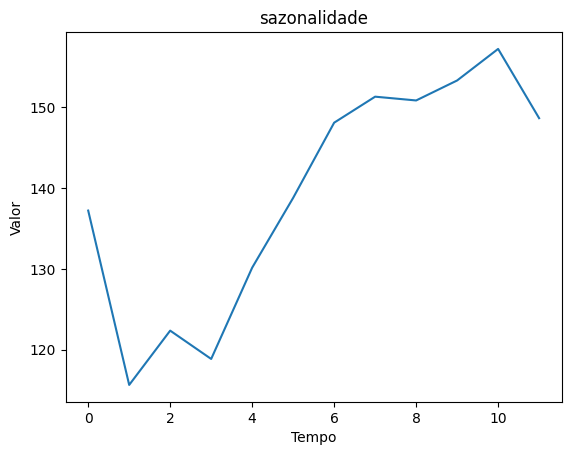

sazonalidade
sazonalidade              
0               137.195563
1               115.654290
2               122.362058
3               118.862696
4               130.139895
5               138.766213
6               148.053851
7               151.268079
8               150.800639
9               153.269548
10              157.167998
11              148.612286

In [30]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [31]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

Unnamed: 0  Pará - IDH Educacao  Pará - Desemprego  \
0       2003-1             0.614461           8.348543   
1       2003-2             0.614718           8.342554   
2       2003-3             0.614976           8.336566   
3       2003-4             0.615233           8.330578   
4       2003-5             0.615490           8.324589   
..         ...                  ...                ...   
244     2023-5                  NaN                NaN   
245     2023-6                  NaN                NaN   
246     2023-7                  NaN                NaN   
247     2023-8                  NaN                NaN   
248     2023-9                  NaN                NaN   

     Pará - Depósito Poupança (R$)  Precipitação (mm/day)  \
0                     2.208327e+06                    NaN   
1                     2.222364e+06                    NaN   
2                     2.236400e+06                    NaN   
3                     2.250437e+06                    NaN   
4                     2.264474e+06                    NaN   
..                             ...                    ...   
244                            NaN                    NaN   
245                            NaN                    NaN   
246                            NaN                    NaN   
247                            NaN                    NaN   
248                            NaN                    NaN   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                         NaN                            NaN   
1                         NaN                            NaN   
2                         NaN                            NaN   
3                         NaN                            NaN   
4                         NaN                            NaN   
..                        ...                            ...   
244                       NaN                            NaN   
245                       NaN                            NaN   
246                       NaN                            NaN   
247                       NaN                            NaN   
248                       NaN                            NaN   

     Temperatura do Ar - Bulbo Seco (°C)  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
..                                   ...   
244                                  NaN   
245                                  NaN   
246                                  NaN   
247                                  NaN   
248                                  NaN   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                     NaN                          NaN   
1                                     NaN                          NaN   
2                                     NaN                          NaN   
3                                     NaN                          NaN   
4                                     NaN                          NaN   
..                                    ...                          ...   
244                                   NaN                          NaN   
245                                   NaN                          NaN   
246                                   NaN                          NaN   
247                                   NaN                          NaN   
248                                   NaN                          NaN   

     Velocidade do Vento (m/s)  Pará - Produção de Cimento (t)  \
0                          NaN                       49.618560   
1                          NaN                       49.658098   
2                          NaN                       49.906876   
3                          NaN                       49.864305   
4                          NaN                       50.1

In [32]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Pará - Consumo de Cimento (t), Length: 249, dtype: float64

In [33]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [35]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

Feature           VIF
0                                 Pará - IDH Educacao  2.305693e+09
1                                   Pará - Desemprego  3.761240e+05
2                       Pará - Depósito Poupança (R$)  3.564019e+05
3                               Precipitação (mm/day)  2.206599e+02
4                            Pressão Atmosférica (mB)  2.399922e+06
5                       Radiação Global - Dia (Kj/m²)  1.180107e+02
6                 Temperatura do Ar - Bulbo Seco (°C)  3.036460e+06
7                Temperatura de Ponto de Orvalho (°C)  1.954741e+06
8                         Humidade Relativa do Ar (%)  1.434116e+06
9                           Velocidade do Vento (m/s)  3.737883e+02
10                     Pará - Produção de Cimento (t)  1.100047e+05
11                            Pará - Preço de Cimento  1.213158e+05
12                             Pará - IDH Longevidade  1.199324e+09
13                                Pará- custo m2 (R$)  2.101808e+06
14                                   Pará - IDH Renda  3.440919e+03
15                                         Pará - IDH  1.406687e+10
16                              Pará - PIB - Estadual  8.934664e+08
17                      Pará - PIB - Construção Civil  3.888521e+07
18                            Pará - PIB - Per Capita  1.045369e+10
19                     Pará - PIB - Preços de Mercado  1.416707e+10
20  Operações de crédito - saldo da carteira de cr...  1.270572e+05
21             Estoque liquido de capital fixo - (R$)  2.721997e+08
22                                EMBI + Risco-Brasil  1.166382e+03
23  Fundo de garantia por tempo de serviço (FGTS) ...  2.118761e+03
24                                             IGP-DI  8.693107e+02
25  Inadimplência da carteira de crédito  - total ...  9.405255e+03
26                                           INCC (%)  3.594326e+03
27    IPCA - Variação mensal durante o Plano Real (%)  6.876141e+03
28             NFSP - Fluxo Mensal (Milhões de reais)  5.766505e+02
29                      NFSP - Porcentagem do PIB (%)  6.738793e+03
30   PIB - Atividades imobiliárias (média 1995 = 100)  4.392089e+05
31                                          População  2.731662e+05
32                                          PPC (US$)  1.506024e+06
33                                     Taxa Selic (%)  1.087702e+02
34                                       sazonalidade  7.594649e+02

In [36]:
data =data.fillna(0.0).drop(['Temperatura do Ar - Bulbo Seco (°C)',
                 'Precipitação (mm/day)',
                 'Radiação Global - Dia (Kj/m²)', 
                 'Humidade Relativa do Ar (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


Pará - Desemprego  Pará - Depósito Poupança (R$)  Precipitação (mm/day)  \
0             8.348543                   2.208327e+06               0.000000   
1             8.342554                   2.222364e+06               0.000000   
2             8.336566                   2.236400e+06               0.000000   
3             8.330578                   2.250437e+06               0.000000   
4             8.324589                   2.264474e+06               0.000000   
..                 ...                            ...                    ...   
175          10.250979                   5.791307e+06               3.390582   
176          10.243000                   5.819657e+06               3.176669   
177          10.235022                   5.848007e+06               3.405575   
178          10.227043                   5.876356e+06               3.474336   
179          10.219064                   5.904706e+06               3.347939   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                    0.000000                       0.000000   
1                    0.000000                       0.000000   
2                    0.000000                       0.000000   
3                    0.000000                       0.000000   
4                    0.000000                       0.000000   
..                        ...                            ...   
175               1009.043898                    1121.157048   
176               1008.628410                    1163.403062   
177               1008.302972                    1146.914875   
178               1008.182759                    1167.026539   
179               1008.231219                    1150.258255   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                0.000000                     0.000000   
1                                0.000000                     0.000000   
2                                0.000000                     0.000000   
3                                0.000000                     0.000000   
4                                0.000000                     0.000000   
..                                    ...                          ...   
175                             22.607433                    76.772118   
176                             22.595219                    76.716789   
177                             22.618844                    77.725841   
178                             22.650711                    78.947908   
179                             22.785003                    80.657270   

     Velocidade do Vento (m/s)  Pará - Produção de Cimento (t)  \
0                     0.000000                       49.618560   
1                     0.000000                       49.658098   
2                     0.000000                       49.906876   
3                     0.000000                       49.864305   
4                     0.000000                       50.179753   
..                         ...                             ...   
175                   0.802919                       91.733516   
176                   0.805581                       90.551229   
177                   0.757239                       89.566725   
178                   0.725443                       88.423018   
179                   0.681378                       87.103930   

     Pará - Preço de Cimento  Pará- custo m2 (R$)  Pará - PIB - Estadual  \
0                   0.312867         10387.404000           7.776091e+07   
1                   0.312657         10470.519385           7.787181e+07   
2                   0.311736         10546.359385           7.798271e+07   
3                   0.310493         10614.915813           7.809361e+07   
4                   0.309128         10682.772020           7.820451e+07   
..                       ...                  ...                    ...   
175                 0.486125         24328.793298           9

In [37]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

Pará - Depósito Poupança (R$)  Precipitação (mm/day)  \
0                        -1.551916              -3.339450   
1                        -1.541392              -3.339450   
2                        -1.530867              -3.339450   
3                        -1.520342              -3.339450   
4                        -1.509818              -3.339450   
..                             ...                    ...   
175                       1.134577               0.581185   
176                       1.155834               0.333830   
177                       1.177090               0.598521   
178                       1.198347               0.678032   
179                       1.219603               0.531876   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                   -3.741646                      -0.809102   
1                   -3.741646                      -0.809102   
2                   -3.741646                      -0.809102   
3                   -3.741646                      -0.809102   
4                   -3.741646                      -0.809102   
..                        ...                            ...   
175                  0.268435                      -0.608263   
176                  0.266783                      -0.600695   
177                  0.265490                      -0.603648   
178                  0.265012                      -0.600046   
179                  0.265205                      -0.603050   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               -3.734461                    -3.709838   
1                               -3.734461                    -3.709838   
2                               -3.734461                    -3.709838   
3                               -3.734461                    -3.709838   
4                               -3.734461                    -3.709838   
..                                    ...                          ...   
175                              0.197993                     0.097358   
176                              0.195869                     0.094614   
177                              0.199978                     0.144654   
178                              0.205521                     0.205258   
179                              0.228881                     0.290026   

     Velocidade do Vento (m/s)  Pará - Produção de Cimento (t)  \
0                    -2.714783                       -1.865796   
1                    -2.714783                       -1.864286   
2                    -2.714783                       -1.854783   
3                    -2.714783                       -1.856409   
4                    -2.714783                       -1.844360   
..                         ...                             ...   
175                  -0.262383                       -0.257106   
176                  -0.254250                       -0.302267   
177                  -0.401906                       -0.339872   
178                  -0.499020                       -0.383559   
179                  -0.633611                       -0.433945   

     Pará - Preço de Cimento  Pará- custo m2 (R$)  Pará - PIB - Estadual  \
0                  -0.944487            -1.545100              -1.611324   
1                  -0.947419            -1.525719              -1.593606   
2                  -0.960256            -1.508034              -1.575887   
3                  -0.977583            -1.492048              -1.558169   
4                  -0.996604            -1.476224              -1.540451   
..                       ...                  ...                    ...   
175                 1.470276             1.705835               1.448487   
176                 1.478894             1.727051               1.450806   
177                 1.487076             1.749003               1.453124   
178                 1.495105             1.770266            

In [38]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

Pará - Depósito Poupança (R$)  Precipitação (mm/day)  \
0                        -1.551916              -3.339450   
1                        -1.541392              -3.339450   
2                        -1.530867              -3.339450   
3                        -1.520342              -3.339450   
4                        -1.509818              -3.339450   
..                             ...                    ...   
163                       0.940259               0.161651   
164                       0.949364              -0.037587   
165                       0.958468               0.124033   
166                       0.967573               0.124172   
167                       0.976678               0.262588   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                   -3.741646                      -0.809102   
1                   -3.741646                      -0.809102   
2                   -3.741646                      -0.809102   
3                   -3.741646                      -0.809102   
4                   -3.741646                      -0.809102   
..                        ...                            ...   
163                  0.269484                      -0.590529   
164                  0.267611                      -0.595828   
165                  0.266028                      -0.603766   
166                  0.265577                      -0.616110   
167                  0.265995                      -0.630884   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               -3.734461                    -3.709838   
1                               -3.734461                    -3.709838   
2                               -3.734461                    -3.709838   
3                               -3.734461                    -3.709838   
4                               -3.734461                    -3.709838   
..                                    ...                          ...   
163                              0.225854                     0.104619   
164                              0.240034                     0.134753   
165                              0.263860                     0.205986   
166                              0.290165                     0.308512   
167                              0.316178                     0.440896   

     Velocidade do Vento (m/s)  Pará - Produção de Cimento (t)  \
0                    -2.714783                       -1.865796   
1                    -2.714783                       -1.864286   
2                    -2.714783                       -1.854783   
3                    -2.714783                       -1.856409   
4                    -2.714783                       -1.844360   
..                         ...                             ...   
163                  -0.139030                        0.299109   
164                  -0.196918                        0.264159   
165                  -0.290180                        0.223045   
166                  -0.490117                        0.196722   
167                  -0.781221                        0.159767   

     Pará - Preço de Cimento  Pará- custo m2 (R$)  Pará - PIB - Estadual  \
0                  -0.944487            -1.545100              -1.611324   
1                  -0.947419            -1.525719              -1.593606   
2                  -0.960256            -1.508034              -1.575887   
3                  -0.977583            -1.492048              -1.558169   
4                  -0.996604            -1.476224              -1.540451   
..                       ...                  ...                    ...   
163                 1.387390             1.469657               1.377835   
164                 1.390076             1.488498               1.388721   
165                 1.393115             1.510036               1.399606   
166                 1.399079             1.527887            

In [39]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
163    133.744
164    128.527
165    147.510
166    138.511
167    103.294
Name: Pará - Consumo de Cimento (t), Length: 168, dtype: float64

In [49]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

Pará - Depósito Poupança (R$)  Precipitação (mm/day)  \
168                       0.985783               0.509195   
169                       1.007039               0.310634   
170                       1.028295               0.314039   
171                       1.049552              -0.104885   
172                       1.070808               0.014536   
173                       1.092065              -0.021823   
174                       1.113321               0.094280   
175                       1.134577               0.581185   
176                       1.155834               0.333830   
177                       1.177090               0.598521   
178                       1.198347               0.678032   
179                       1.219603               0.531876   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
168                  0.266359                      -0.636656   
169                  0.266784                      -0.633782   
170                  0.267623                      -0.626081   
171                  0.269373                      -0.609229   
172                  0.270487                      -0.599600   
173                  0.271130                      -0.595653   
174                  0.270676                      -0.604935   
175                  0.268435                      -0.608263   
176                  0.266783                      -0.600695   
177                  0.265490                      -0.603648   
178                  0.265012                      -0.600046   
179                  0.265205                      -0.603050   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
168                              0.327350                     0.497280   
169                              0.329644                     0.496235   
170                              0.319719                     0.451973   
171                              0.273214                     0.331769   
172                              0.243398                     0.245941   
173                              0.210932                     0.159744   
174                              0.192412                     0.113725   
175                              0.197993                     0.097358   
176                              0.195869                     0.094614   
177                              0.199978                     0.144654   
178                              0.205521                     0.205258   
179                              0.228881                     0.290026   

     Velocidade do Vento (m/s)  Pará - Produção de Cimento (t)  \
168                  -0.888873                        0.109807   
169                  -0.872119                        0.051056   
170                  -0.778401                        0.012292   
171                  -0.551913                       -0.046476   
172                  -0.405113                       -0.096337   
173                  -0.252665                       -0.143393   
174                  -0.243281                       -0.200354   
175                  -0.262383                       -0.257106   
176                  -0.254250                       -0.302267   
177                  -0.401906                       -0.339872   
178                  -0.499020                       -0.383559   
179                  -0.633611                       -0.433945   

     Pará - Preço de Cimento  Pará- custo m2 (R$)  Pará - PIB - Estadual  \
168                 1.413162             1.565149               1.432261   
169                 1.420345             1.583804               1.434579   
170                 1.426980             1.602424               1.436897   
171                 1.435515             1.622773               1.439215   
172                 1.442893             1.643055               1.441533   
173                 1.451630             1.663700               1.443851   
174                 1.46

In [41]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    110.704
169     91.638
170     90.744
171     82.108
172     97.490
173     96.803
174    118.687
175    109.761
176    120.188
177    131.620
178    125.374
179    115.811
Name: Pará - Consumo de Cimento (t), dtype: float64

In [53]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_split=0.07,
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [54]:
winner_seed = 1464401285

In [55]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)
# 1464401285

24

Epoch 1/10000
5/5 [==============================] - 1s 27ms/step - loss: 18583.8340 - val_loss: 26594.8340
Epoch 2/10000
5/5 [==============================] - 0s 4ms/step - loss: 21741.3379 - val_loss: 15061.6709
Epoch 3/10000
5/5 [==============================] - 0s 5ms/step - loss: 17539.8301 - val_loss: 4826.7822
Epoch 4/10000
5/5 [==============================] - 0s 5ms/step - loss: 10002.2793 - val_loss: 25662.6582
Epoch 5/10000
5/5 [==============================] - 0s 5ms/step - loss: 7758.8628 - val_loss: 827.7432
Epoch 6/10000
5/5 [==============================] - 0s 4ms/step - loss: 6106.9946 - val_loss: 944.3737
Epoch 7/10000
5/5 [==============================] - 0s 5ms/step - loss: 2019.7919 - val_loss: 904.4754
Epoch 8/10000
5/5 [==============================] - 0s 5ms/step - loss: 2538.3296 - val_loss: 2118.7920
Epoch 9/10000
5/5 [==============================] - 0s 5ms/step - loss: 2547.0103 - val_loss: 2725.4534
Epoch 10/10000
5/5 [==============================

Epoch 79/10000
5/5 [==============================] - 0s 4ms/step - loss: 457.2965 - val_loss: 6437.8579
Epoch 80/10000
5/5 [==============================] - 0s 5ms/step - loss: 444.9715 - val_loss: 6516.3315
Epoch 81/10000
5/5 [==============================] - 0s 5ms/step - loss: 599.3146 - val_loss: 6435.3081
Epoch 82/10000
5/5 [==============================] - 0s 4ms/step - loss: 573.1944 - val_loss: 2288.0901
Epoch 83/10000
5/5 [==============================] - 0s 4ms/step - loss: 631.3492 - val_loss: 3525.3665
Epoch 84/10000
5/5 [==============================] - 0s 4ms/step - loss: 600.6755 - val_loss: 4206.9580
Epoch 85/10000
5/5 [==============================] - 0s 4ms/step - loss: 1090.5740 - val_loss: 6942.9160
Epoch 86/10000
5/5 [==============================] - 0s 5ms/step - loss: 1237.6184 - val_loss: 6879.5835
Epoch 87/10000
5/5 [==============================] - 0s 4ms/step - loss: 1785.0507 - val_loss: 7763.2827
Epoch 88/10000
5/5 [==============================] 

5/5 [==============================] - 0s 5ms/step - loss: 654.0284 - val_loss: 2767.2004
Epoch 157/10000
5/5 [==============================] - 0s 4ms/step - loss: 547.8727 - val_loss: 2642.6841
Epoch 158/10000
5/5 [==============================] - 0s 4ms/step - loss: 685.7990 - val_loss: 1941.2006
Epoch 159/10000
5/5 [==============================] - 0s 4ms/step - loss: 754.2120 - val_loss: 1448.6830
Epoch 160/10000
5/5 [==============================] - 0s 4ms/step - loss: 734.8856 - val_loss: 1873.9149
Epoch 161/10000
5/5 [==============================] - 0s 4ms/step - loss: 545.8914 - val_loss: 2758.5947
Epoch 162/10000
5/5 [==============================] - 0s 5ms/step - loss: 546.2972 - val_loss: 2530.5781
Epoch 163/10000
5/5 [==============================] - 0s 4ms/step - loss: 573.1812 - val_loss: 2332.1370
Epoch 164/10000
5/5 [==============================] - 0s 4ms/step - loss: 608.8730 - val_loss: 1987.8876
Epoch 165/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 5ms/step - loss: 609.8665 - val_loss: 2208.8149
Epoch 234/10000
5/5 [==============================] - 0s 4ms/step - loss: 582.1152 - val_loss: 753.2005
Epoch 235/10000
5/5 [==============================] - 0s 5ms/step - loss: 862.4845 - val_loss: 1881.7455
Epoch 236/10000
5/5 [==============================] - 0s 5ms/step - loss: 981.7957 - val_loss: 1240.8392
Epoch 237/10000
5/5 [==============================] - 0s 5ms/step - loss: 1037.3107 - val_loss: 1377.4487
Epoch 238/10000
5/5 [==============================] - 0s 5ms/step - loss: 1113.8077 - val_loss: 1101.1530
Epoch 239/10000
5/5 [==============================] - 0s 5ms/step - loss: 779.2923 - val_loss: 809.3847
Epoch 240/10000
5/5 [==============================] - 0s 5ms/step - loss: 891.5521 - val_loss: 2233.8792
Epoch 241/10000
5/5 [==============================] - 0s 5ms/step - loss: 1004.4900 - val_loss: 978.8933
Epoch 242/10000
5/5 [==============================] - 0s 5ms/

5/5 [==============================] - 0s 4ms/step - loss: 588.4972 - val_loss: 1563.2871
Epoch 311/10000
5/5 [==============================] - 0s 5ms/step - loss: 613.6362 - val_loss: 1764.8099
Epoch 312/10000
5/5 [==============================] - 0s 5ms/step - loss: 620.8291 - val_loss: 1740.3239
Epoch 313/10000
5/5 [==============================] - 0s 4ms/step - loss: 615.5408 - val_loss: 1675.1791
Epoch 314/10000
5/5 [==============================] - 0s 4ms/step - loss: 577.7136 - val_loss: 1540.7651
Epoch 315/10000
5/5 [==============================] - 0s 5ms/step - loss: 580.1653 - val_loss: 1697.9437
Epoch 316/10000
5/5 [==============================] - 0s 5ms/step - loss: 539.0934 - val_loss: 1676.0013
Epoch 317/10000
5/5 [==============================] - 0s 5ms/step - loss: 556.6161 - val_loss: 1309.5677
Epoch 318/10000
5/5 [==============================] - 0s 4ms/step - loss: 670.9100 - val_loss: 1425.1556
Epoch 319/10000
5/5 [==============================] - 0s 5ms/

5/5 [==============================] - 0s 5ms/step - loss: 633.0161 - val_loss: 916.9707
Epoch 388/10000
5/5 [==============================] - 0s 4ms/step - loss: 607.0883 - val_loss: 926.3918
Epoch 389/10000
5/5 [==============================] - 0s 4ms/step - loss: 697.4180 - val_loss: 978.9816
Epoch 390/10000
5/5 [==============================] - 0s 5ms/step - loss: 634.0082 - val_loss: 1721.2006
Epoch 391/10000
5/5 [==============================] - 0s 4ms/step - loss: 784.9658 - val_loss: 1947.3081
Epoch 392/10000
5/5 [==============================] - 0s 5ms/step - loss: 657.4883 - val_loss: 1827.7325
Epoch 393/10000
5/5 [==============================] - 0s 5ms/step - loss: 729.0079 - val_loss: 1972.1320
Epoch 394/10000
5/5 [==============================] - 0s 5ms/step - loss: 713.8232 - val_loss: 1986.5612
Epoch 395/10000
5/5 [==============================] - 0s 5ms/step - loss: 689.7965 - val_loss: 1852.7633
Epoch 396/10000
5/5 [==============================] - 0s 5ms/ste

5/5 [==============================] - 0s 5ms/step - loss: 628.1827 - val_loss: 2375.1660
Epoch 465/10000
5/5 [==============================] - 0s 5ms/step - loss: 656.6411 - val_loss: 2743.0730
Epoch 466/10000
5/5 [==============================] - 0s 5ms/step - loss: 630.4594 - val_loss: 2768.3479
Epoch 467/10000
5/5 [==============================] - 0s 5ms/step - loss: 633.0823 - val_loss: 2661.2610
Epoch 468/10000
5/5 [==============================] - 0s 4ms/step - loss: 645.5155 - val_loss: 1669.4515
Epoch 469/10000
5/5 [==============================] - 0s 4ms/step - loss: 605.4076 - val_loss: 1654.9974
Epoch 470/10000
5/5 [==============================] - 0s 5ms/step - loss: 640.1087 - val_loss: 1928.5953
Epoch 471/10000
5/5 [==============================] - 0s 5ms/step - loss: 642.4261 - val_loss: 1655.6606
Epoch 472/10000
5/5 [==============================] - 0s 4ms/step - loss: 641.9896 - val_loss: 1627.6949
Epoch 473/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 707.2553 - val_loss: 1016.1091
Epoch 542/10000
5/5 [==============================] - 0s 4ms/step - loss: 664.0101 - val_loss: 961.1760
Epoch 543/10000
5/5 [==============================] - 0s 4ms/step - loss: 621.4703 - val_loss: 953.9401
Epoch 544/10000
5/5 [==============================] - 0s 4ms/step - loss: 640.3183 - val_loss: 947.5161
Epoch 545/10000
5/5 [==============================] - 0s 4ms/step - loss: 626.4914 - val_loss: 942.1787
Epoch 546/10000
5/5 [==============================] - 0s 4ms/step - loss: 660.1528 - val_loss: 972.0193
Epoch 547/10000
5/5 [==============================] - 0s 4ms/step - loss: 628.2242 - val_loss: 930.6487
Epoch 548/10000
5/5 [==============================] - 0s 4ms/step - loss: 625.4795 - val_loss: 934.5320
Epoch 549/10000
5/5 [==============================] - 0s 4ms/step - loss: 611.8581 - val_loss: 923.8660
Epoch 550/10000
5/5 [==============================] - 0s 4ms/step - l

5/5 [==============================] - 0s 5ms/step - loss: 625.8119 - val_loss: 1300.5009
Epoch 619/10000
5/5 [==============================] - 0s 4ms/step - loss: 613.2691 - val_loss: 1334.0739
Epoch 620/10000
5/5 [==============================] - 0s 4ms/step - loss: 642.3331 - val_loss: 1269.4368
Epoch 621/10000
5/5 [==============================] - 0s 5ms/step - loss: 649.4868 - val_loss: 1320.0391
Epoch 622/10000
5/5 [==============================] - 0s 4ms/step - loss: 629.7887 - val_loss: 1343.0535
Epoch 623/10000
5/5 [==============================] - 0s 4ms/step - loss: 599.3361 - val_loss: 1288.5186
Epoch 624/10000
5/5 [==============================] - 0s 4ms/step - loss: 660.2044 - val_loss: 1305.7908
Epoch 625/10000
5/5 [==============================] - 0s 4ms/step - loss: 660.6126 - val_loss: 1280.5667
Epoch 626/10000
5/5 [==============================] - 0s 5ms/step - loss: 680.0413 - val_loss: 1247.2141
Epoch 627/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 5ms/step - loss: 669.9167 - val_loss: 1012.5076
Epoch 696/10000
5/5 [==============================] - 0s 4ms/step - loss: 652.8958 - val_loss: 980.9534
Epoch 697/10000
5/5 [==============================] - 0s 4ms/step - loss: 579.7816 - val_loss: 1024.4240
Epoch 698/10000
5/5 [==============================] - 0s 4ms/step - loss: 587.4656 - val_loss: 1041.2821
Epoch 699/10000
5/5 [==============================] - 0s 4ms/step - loss: 614.4672 - val_loss: 1021.6839
Epoch 700/10000
5/5 [==============================] - 0s 4ms/step - loss: 588.0026 - val_loss: 1127.6465
Epoch 701/10000
5/5 [==============================] - 0s 4ms/step - loss: 627.9475 - val_loss: 1089.3580
Epoch 702/10000
5/5 [==============================] - 0s 4ms/step - loss: 561.3912 - val_loss: 1103.8250
Epoch 703/10000
5/5 [==============================] - 0s 5ms/step - loss: 543.1846 - val_loss: 1144.1139
Epoch 704/10000
5/5 [==============================] - 0s 4ms/s

5/5 [==============================] - 0s 5ms/step - loss: 591.7592 - val_loss: 1415.0747
Epoch 773/10000
5/5 [==============================] - 0s 5ms/step - loss: 590.7900 - val_loss: 1284.4353
Epoch 774/10000
5/5 [==============================] - 0s 4ms/step - loss: 581.6993 - val_loss: 1313.5120
Epoch 775/10000
5/5 [==============================] - 0s 5ms/step - loss: 611.1586 - val_loss: 868.3550
Epoch 776/10000
5/5 [==============================] - 0s 5ms/step - loss: 574.4756 - val_loss: 871.1545
Epoch 777/10000
5/5 [==============================] - 0s 4ms/step - loss: 613.1124 - val_loss: 885.1355
Epoch 778/10000
5/5 [==============================] - 0s 4ms/step - loss: 561.6474 - val_loss: 1289.5571
Epoch 779/10000
5/5 [==============================] - 0s 5ms/step - loss: 565.4564 - val_loss: 1325.1135
Epoch 780/10000
5/5 [==============================] - 0s 5ms/step - loss: 553.0719 - val_loss: 1332.2736
Epoch 781/10000
5/5 [==============================] - 0s 4ms/ste

5/5 [==============================] - 0s 5ms/step - loss: 535.6240 - val_loss: 1147.3591
Epoch 850/10000
5/5 [==============================] - 0s 4ms/step - loss: 547.4761 - val_loss: 1459.4540
Epoch 851/10000
5/5 [==============================] - 0s 5ms/step - loss: 551.0662 - val_loss: 1214.8300
Epoch 852/10000
5/5 [==============================] - 0s 5ms/step - loss: 533.3942 - val_loss: 1168.0325
Epoch 853/10000
5/5 [==============================] - 0s 4ms/step - loss: 512.1423 - val_loss: 1176.5884
Epoch 854/10000
5/5 [==============================] - 0s 4ms/step - loss: 524.0546 - val_loss: 1163.3932
Epoch 855/10000
5/5 [==============================] - 0s 5ms/step - loss: 547.2505 - val_loss: 1198.0189
Epoch 856/10000
5/5 [==============================] - 0s 4ms/step - loss: 544.1325 - val_loss: 1249.9141
Epoch 857/10000
5/5 [==============================] - 0s 5ms/step - loss: 536.7590 - val_loss: 1269.6838
Epoch 858/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 5ms/step - loss: 542.1771 - val_loss: 2192.5176
Epoch 927/10000
5/5 [==============================] - 0s 5ms/step - loss: 549.2207 - val_loss: 2153.9629
Epoch 928/10000
5/5 [==============================] - 0s 4ms/step - loss: 556.4869 - val_loss: 2135.0764
Epoch 929/10000
5/5 [==============================] - 0s 5ms/step - loss: 545.7858 - val_loss: 1450.1582
Epoch 930/10000
5/5 [==============================] - 0s 5ms/step - loss: 523.8696 - val_loss: 1428.3823
Epoch 931/10000
5/5 [==============================] - 0s 5ms/step - loss: 539.5625 - val_loss: 1476.7538
Epoch 932/10000
5/5 [==============================] - 0s 4ms/step - loss: 519.7720 - val_loss: 1471.7314
Epoch 933/10000
5/5 [==============================] - 0s 4ms/step - loss: 515.8168 - val_loss: 1528.9160
Epoch 934/10000
5/5 [==============================] - 0s 5ms/step - loss: 537.8969 - val_loss: 1498.4478
Epoch 935/10000
5/5 [==============================] - 0s 5ms/

5/5 [==============================] - 0s 5ms/step - loss: 508.4294 - val_loss: 1149.8707
Epoch 1004/10000
5/5 [==============================] - 0s 5ms/step - loss: 568.9671 - val_loss: 1208.0229
Epoch 1005/10000
5/5 [==============================] - 0s 5ms/step - loss: 532.2161 - val_loss: 1127.6997
Epoch 1006/10000
5/5 [==============================] - 0s 4ms/step - loss: 537.5909 - val_loss: 1099.1101
Epoch 1007/10000
5/5 [==============================] - 0s 4ms/step - loss: 535.6836 - val_loss: 1129.1785
Epoch 1008/10000
5/5 [==============================] - 0s 4ms/step - loss: 517.3994 - val_loss: 1155.1727
Epoch 1009/10000
5/5 [==============================] - 0s 5ms/step - loss: 526.7555 - val_loss: 1060.0466
Epoch 1010/10000
5/5 [==============================] - 0s 5ms/step - loss: 513.2515 - val_loss: 1154.0759
Epoch 1011/10000
5/5 [==============================] - 0s 4ms/step - loss: 503.0447 - val_loss: 1079.9924
Epoch 1012/10000
5/5 [==============================] 

Epoch 1080/10000
5/5 [==============================] - 0s 4ms/step - loss: 467.9614 - val_loss: 1057.9976
Epoch 1081/10000
5/5 [==============================] - 0s 4ms/step - loss: 468.9152 - val_loss: 1024.9832
Epoch 1082/10000
5/5 [==============================] - 0s 4ms/step - loss: 468.1286 - val_loss: 1100.2942
Epoch 1083/10000
5/5 [==============================] - 0s 4ms/step - loss: 478.6498 - val_loss: 1097.2947
Epoch 1084/10000
5/5 [==============================] - 0s 4ms/step - loss: 468.0884 - val_loss: 1059.3018
Epoch 1085/10000
5/5 [==============================] - 0s 5ms/step - loss: 496.9279 - val_loss: 1057.4889
Epoch 1086/10000
5/5 [==============================] - 0s 5ms/step - loss: 524.6454 - val_loss: 1046.3044
Epoch 1087/10000
5/5 [==============================] - 0s 4ms/step - loss: 476.9087 - val_loss: 1122.9388
Epoch 1088/10000
5/5 [==============================] - 0s 4ms/step - loss: 507.1911 - val_loss: 1075.2859
Epoch 1089/10000
5/5 [===============

5/5 [==============================] - 0s 4ms/step - loss: 494.2037 - val_loss: 1480.4222
Epoch 1157/10000
5/5 [==============================] - 0s 4ms/step - loss: 483.8621 - val_loss: 1449.8160
Epoch 1158/10000
5/5 [==============================] - 0s 4ms/step - loss: 507.9006 - val_loss: 1414.5573
Epoch 1159/10000
5/5 [==============================] - 0s 4ms/step - loss: 481.9223 - val_loss: 1407.5719
Epoch 1160/10000
5/5 [==============================] - 0s 4ms/step - loss: 480.6983 - val_loss: 1569.7069
Epoch 1161/10000
5/5 [==============================] - 0s 4ms/step - loss: 499.0880 - val_loss: 1668.0220
Epoch 1162/10000
5/5 [==============================] - 0s 4ms/step - loss: 506.3845 - val_loss: 1510.7660
Epoch 1163/10000
5/5 [==============================] - 0s 5ms/step - loss: 520.1190 - val_loss: 1410.6724
Epoch 1164/10000
5/5 [==============================] - 0s 4ms/step - loss: 486.5344 - val_loss: 1376.5118
Epoch 1165/10000
5/5 [==============================] 

Epoch 1233/10000
5/5 [==============================] - 0s 5ms/step - loss: 473.6658 - val_loss: 955.9819
Epoch 1234/10000
5/5 [==============================] - 0s 4ms/step - loss: 480.9678 - val_loss: 939.2767
Epoch 1235/10000
5/5 [==============================] - 0s 4ms/step - loss: 476.8454 - val_loss: 986.8796
Epoch 1236/10000
5/5 [==============================] - 0s 4ms/step - loss: 458.0647 - val_loss: 990.8509
Epoch 1237/10000
5/5 [==============================] - 0s 4ms/step - loss: 465.6709 - val_loss: 990.0202
Epoch 1238/10000
5/5 [==============================] - 0s 4ms/step - loss: 435.7905 - val_loss: 982.7027
Epoch 1239/10000
5/5 [==============================] - 0s 4ms/step - loss: 459.7265 - val_loss: 995.7137
Epoch 1240/10000
5/5 [==============================] - 0s 4ms/step - loss: 458.2953 - val_loss: 981.4739
Epoch 1241/10000
5/5 [==============================] - 0s 4ms/step - loss: 453.8104 - val_loss: 969.0931
Epoch 1242/10000
5/5 [========================

5/5 [==============================] - 0s 5ms/step - loss: 533.4390 - val_loss: 1424.3109
Epoch 1311/10000
5/5 [==============================] - 0s 5ms/step - loss: 510.7794 - val_loss: 1279.8689
Epoch 1312/10000
5/5 [==============================] - 0s 4ms/step - loss: 518.5270 - val_loss: 1436.3524
Epoch 1313/10000
5/5 [==============================] - 0s 4ms/step - loss: 521.4025 - val_loss: 1626.1754
Epoch 1314/10000
5/5 [==============================] - 0s 4ms/step - loss: 545.7100 - val_loss: 1306.8625
Epoch 1315/10000
5/5 [==============================] - 0s 4ms/step - loss: 548.4966 - val_loss: 1091.0852
Epoch 1316/10000
5/5 [==============================] - 0s 4ms/step - loss: 592.2005 - val_loss: 1166.6335
Epoch 1317/10000
5/5 [==============================] - 0s 4ms/step - loss: 542.1118 - val_loss: 1217.6865
Epoch 1318/10000
5/5 [==============================] - 0s 4ms/step - loss: 581.5294 - val_loss: 1211.9133
Epoch 1319/10000
5/5 [==============================] 

Epoch 1387/10000
5/5 [==============================] - 0s 5ms/step - loss: 556.8260 - val_loss: 964.9850
Epoch 1388/10000
5/5 [==============================] - 0s 5ms/step - loss: 560.9919 - val_loss: 969.2595
Epoch 1389/10000
5/5 [==============================] - 0s 5ms/step - loss: 547.6759 - val_loss: 980.8123
Epoch 1390/10000
5/5 [==============================] - 0s 4ms/step - loss: 520.0303 - val_loss: 1004.8682
Epoch 1391/10000
5/5 [==============================] - 0s 4ms/step - loss: 555.1313 - val_loss: 1042.7634
Epoch 1392/10000
5/5 [==============================] - 0s 4ms/step - loss: 592.0601 - val_loss: 1154.5646
Epoch 1393/10000
5/5 [==============================] - 0s 4ms/step - loss: 574.0604 - val_loss: 1215.8423
Epoch 1394/10000
5/5 [==============================] - 0s 4ms/step - loss: 569.1797 - val_loss: 1234.4536
Epoch 1395/10000
5/5 [==============================] - 0s 4ms/step - loss: 597.2898 - val_loss: 1096.8981
Epoch 1396/10000
5/5 [==================

5/5 [==============================] - 0s 4ms/step - loss: 595.5214 - val_loss: 1522.5244
Epoch 1464/10000
5/5 [==============================] - 0s 5ms/step - loss: 674.0128 - val_loss: 1696.3524
Epoch 1465/10000
5/5 [==============================] - 0s 4ms/step - loss: 629.8139 - val_loss: 1641.9340
Epoch 1466/10000
5/5 [==============================] - 0s 5ms/step - loss: 504.8907 - val_loss: 1956.0963
Epoch 1467/10000
5/5 [==============================] - 0s 5ms/step - loss: 516.4224 - val_loss: 1857.3546
Epoch 1468/10000
5/5 [==============================] - 0s 5ms/step - loss: 520.8516 - val_loss: 1754.5016
Epoch 1469/10000
5/5 [==============================] - 0s 4ms/step - loss: 574.2038 - val_loss: 1663.9301
Epoch 1470/10000
5/5 [==============================] - 0s 4ms/step - loss: 610.1427 - val_loss: 1669.9683
Epoch 1471/10000
5/5 [==============================] - 0s 4ms/step - loss: 509.1424 - val_loss: 1673.5255
Epoch 1472/10000
5/5 [==============================] 

5/5 [==============================] - 0s 5ms/step - loss: 499.8146 - val_loss: 1083.7681
Epoch 1540/10000
5/5 [==============================] - 0s 4ms/step - loss: 491.4307 - val_loss: 998.9252
Epoch 1541/10000
5/5 [==============================] - 0s 5ms/step - loss: 488.4967 - val_loss: 1046.4835
Epoch 1542/10000
5/5 [==============================] - 0s 4ms/step - loss: 479.3214 - val_loss: 1078.4036
Epoch 1543/10000
5/5 [==============================] - 0s 5ms/step - loss: 510.0546 - val_loss: 1141.0703
Epoch 1544/10000
5/5 [==============================] - 0s 4ms/step - loss: 513.3336 - val_loss: 1117.6244
Epoch 1545/10000
5/5 [==============================] - 0s 5ms/step - loss: 487.2595 - val_loss: 1127.8879
Epoch 1546/10000
5/5 [==============================] - 0s 4ms/step - loss: 507.0434 - val_loss: 1069.2610
Epoch 1547/10000
5/5 [==============================] - 0s 4ms/step - loss: 493.1493 - val_loss: 991.8162
Epoch 1548/10000
5/5 [==============================] - 

5/5 [==============================] - 0s 4ms/step - loss: 476.8288 - val_loss: 1002.2282
Epoch 1617/10000
5/5 [==============================] - 0s 4ms/step - loss: 463.6794 - val_loss: 1064.6007
Epoch 1618/10000
5/5 [==============================] - 0s 4ms/step - loss: 499.7626 - val_loss: 1077.1678
Epoch 1619/10000
5/5 [==============================] - 0s 5ms/step - loss: 550.0056 - val_loss: 1039.6472
Epoch 1620/10000
5/5 [==============================] - 0s 4ms/step - loss: 493.6791 - val_loss: 964.5271
Epoch 1621/10000
5/5 [==============================] - 0s 4ms/step - loss: 498.4613 - val_loss: 952.7265
Epoch 1622/10000
5/5 [==============================] - 0s 4ms/step - loss: 472.2360 - val_loss: 906.0173
Epoch 1623/10000
5/5 [==============================] - 0s 4ms/step - loss: 492.0431 - val_loss: 1003.3148
Epoch 1624/10000
5/5 [==============================] - 0s 5ms/step - loss: 510.1612 - val_loss: 997.1736
Epoch 1625/10000
5/5 [==============================] - 0s

5/5 [==============================] - 0s 4ms/step - loss: 449.7509 - val_loss: 1040.6592
Epoch 1694/10000
5/5 [==============================] - 0s 5ms/step - loss: 503.5152 - val_loss: 1118.9968
Epoch 1695/10000
5/5 [==============================] - 0s 5ms/step - loss: 462.1163 - val_loss: 1044.1655
Epoch 1696/10000
5/5 [==============================] - 0s 4ms/step - loss: 444.2793 - val_loss: 1155.4351
Epoch 1697/10000
5/5 [==============================] - 0s 4ms/step - loss: 472.3633 - val_loss: 1103.7876
Epoch 1698/10000
5/5 [==============================] - 0s 4ms/step - loss: 444.6844 - val_loss: 1101.2511
Epoch 1699/10000
5/5 [==============================] - 0s 5ms/step - loss: 466.0878 - val_loss: 1016.6365
Epoch 1700/10000
5/5 [==============================] - 0s 4ms/step - loss: 457.5721 - val_loss: 1134.5679
Epoch 1701/10000
5/5 [==============================] - 0s 4ms/step - loss: 456.8332 - val_loss: 1130.9819
Epoch 1702/10000
5/5 [==============================] 

Epoch 1770/10000
5/5 [==============================] - 0s 5ms/step - loss: 460.1664 - val_loss: 1124.1880
Epoch 1771/10000
5/5 [==============================] - 0s 5ms/step - loss: 479.0536 - val_loss: 1034.8052
Epoch 1772/10000
5/5 [==============================] - 0s 4ms/step - loss: 457.2251 - val_loss: 1096.2041
Epoch 1773/10000
5/5 [==============================] - 0s 5ms/step - loss: 459.0345 - val_loss: 1073.5093
Epoch 1774/10000
5/5 [==============================] - 0s 5ms/step - loss: 454.2234 - val_loss: 1061.8926
Epoch 1775/10000
5/5 [==============================] - 0s 5ms/step - loss: 435.8211 - val_loss: 1054.0562
Epoch 1776/10000
5/5 [==============================] - 0s 4ms/step - loss: 433.5093 - val_loss: 1077.0138
Epoch 1777/10000
5/5 [==============================] - 0s 4ms/step - loss: 448.8959 - val_loss: 1116.5555
Epoch 1778/10000
5/5 [==============================] - 0s 4ms/step - loss: 441.6466 - val_loss: 1080.0095
Epoch 1779/10000
5/5 [===============

Epoch 1847/10000
5/5 [==============================] - 0s 4ms/step - loss: 448.4868 - val_loss: 958.6259
Epoch 1848/10000
5/5 [==============================] - 0s 4ms/step - loss: 444.8247 - val_loss: 976.1067
Epoch 1849/10000
5/5 [==============================] - 0s 4ms/step - loss: 442.3141 - val_loss: 953.8646
Epoch 1850/10000
5/5 [==============================] - 0s 4ms/step - loss: 468.2653 - val_loss: 941.7996
Epoch 1851/10000
5/5 [==============================] - 0s 4ms/step - loss: 455.1758 - val_loss: 772.8343
Epoch 1852/10000
5/5 [==============================] - 0s 4ms/step - loss: 428.8834 - val_loss: 796.5150
Epoch 1853/10000
5/5 [==============================] - 0s 4ms/step - loss: 421.1643 - val_loss: 814.3221
Epoch 1854/10000
5/5 [==============================] - 0s 6ms/step - loss: 434.0995 - val_loss: 813.2421
Epoch 1854: early stopping


In [56]:
trained_model.save('model_pa.keras')

In [69]:
def f(X):
    model = tf.keras.models.load_model('model_pa.keras')
    return model.predict(X)

def shap_explainer(train_input, test_input, test_target):
    explainer = shap.KernelExplainer(f, pd.DataFrame(np.zeros((1, len(train_input.columns.tolist()))), columns=test_input.columns))
    shap_values = explainer.shap_values(test_input)
    exp = shap.Explanation(shap_values[0], explainer.expected_value, test_input, feature_names=test_input.columns)
    display(shap.waterfall_plot(exp[0]))
#     display(shap.summary_plot(shap_values, features=test_input))
    display(shap.decision_plot(test_target, shap_values[0], test_input))
    return shap_values[0][0], explainer

def mae_mape_calculator(model, train_input, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        input_i = test_input[i:i+1]
        prediction = model.predict(input_i)
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        info = [f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]]
        results_data.append(info)
        shap_calc_values, exp = shap_explainer(train_input, input_i, target)
        display(info)

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 570us/step


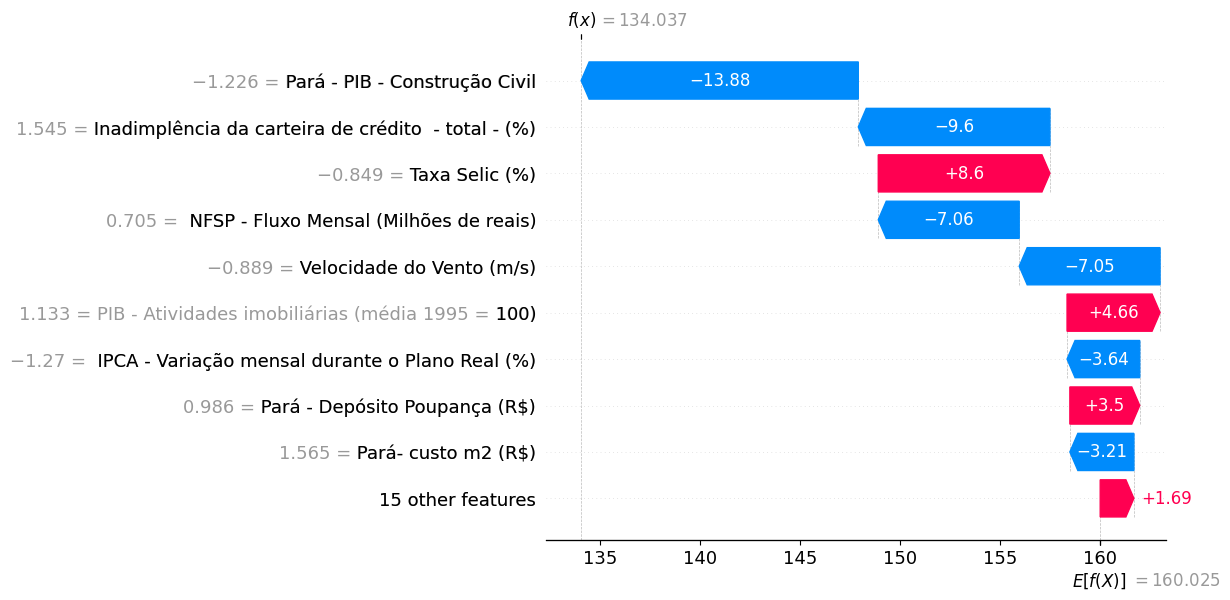

None

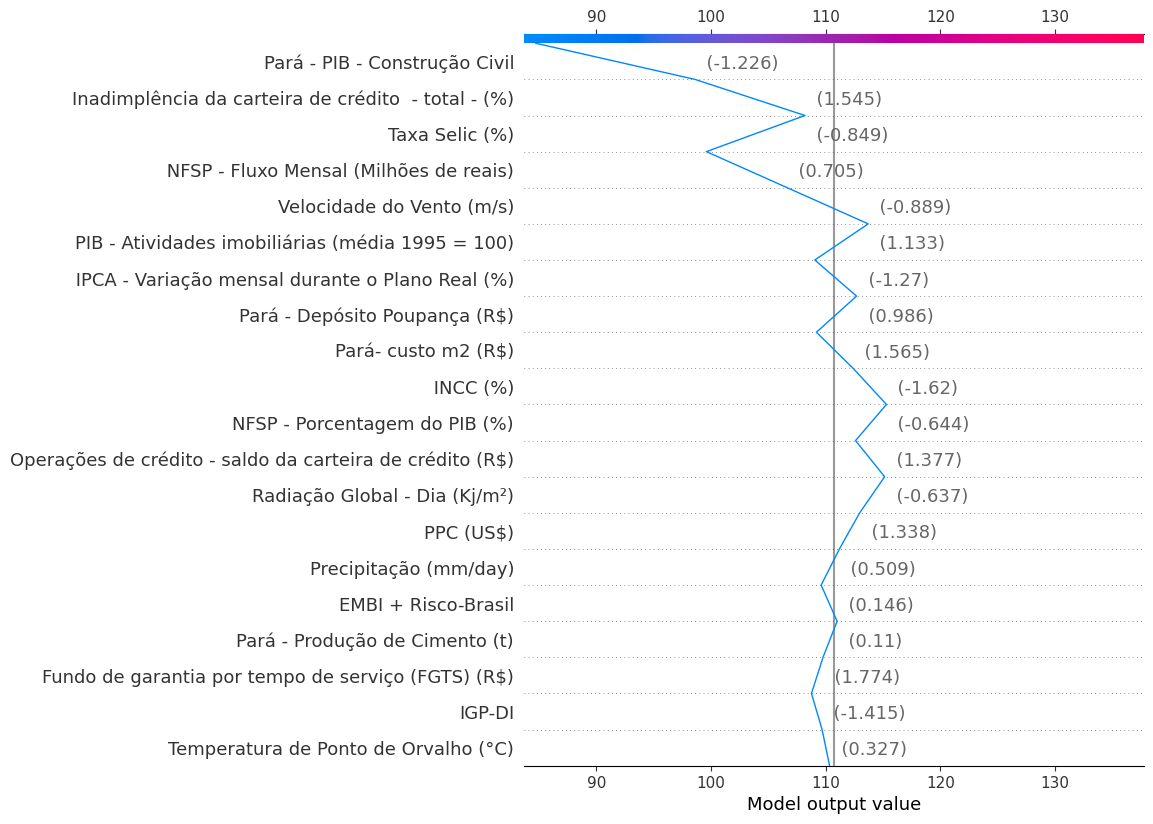

None

['Month-1', 134.03688, 110.704, 23.332878]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 570us/step


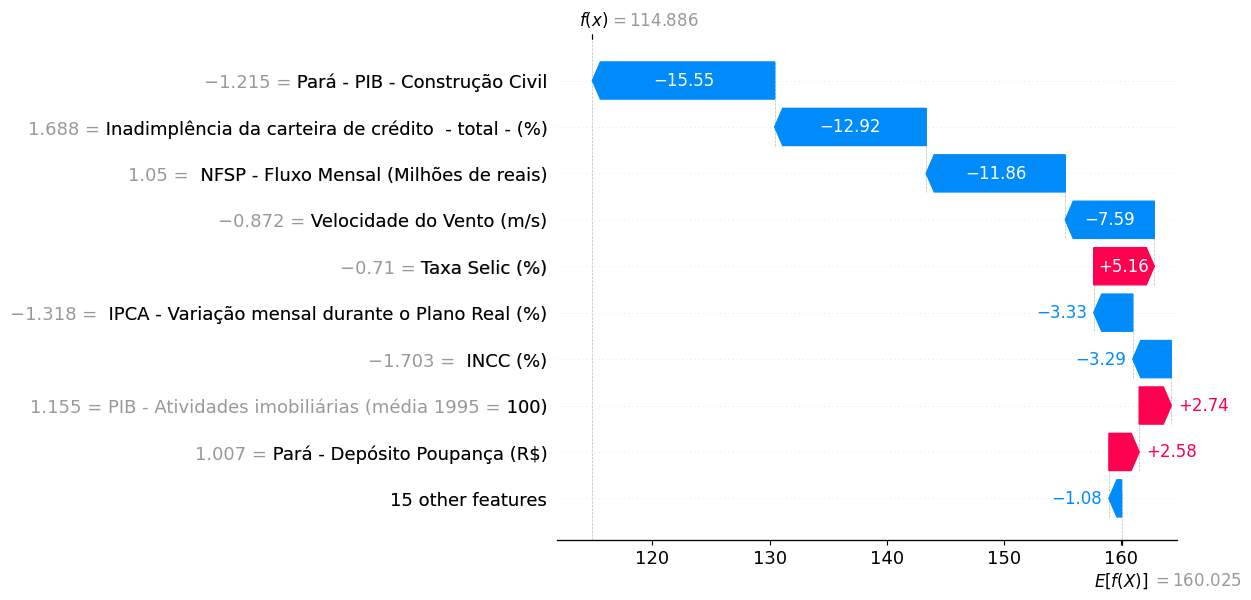

None

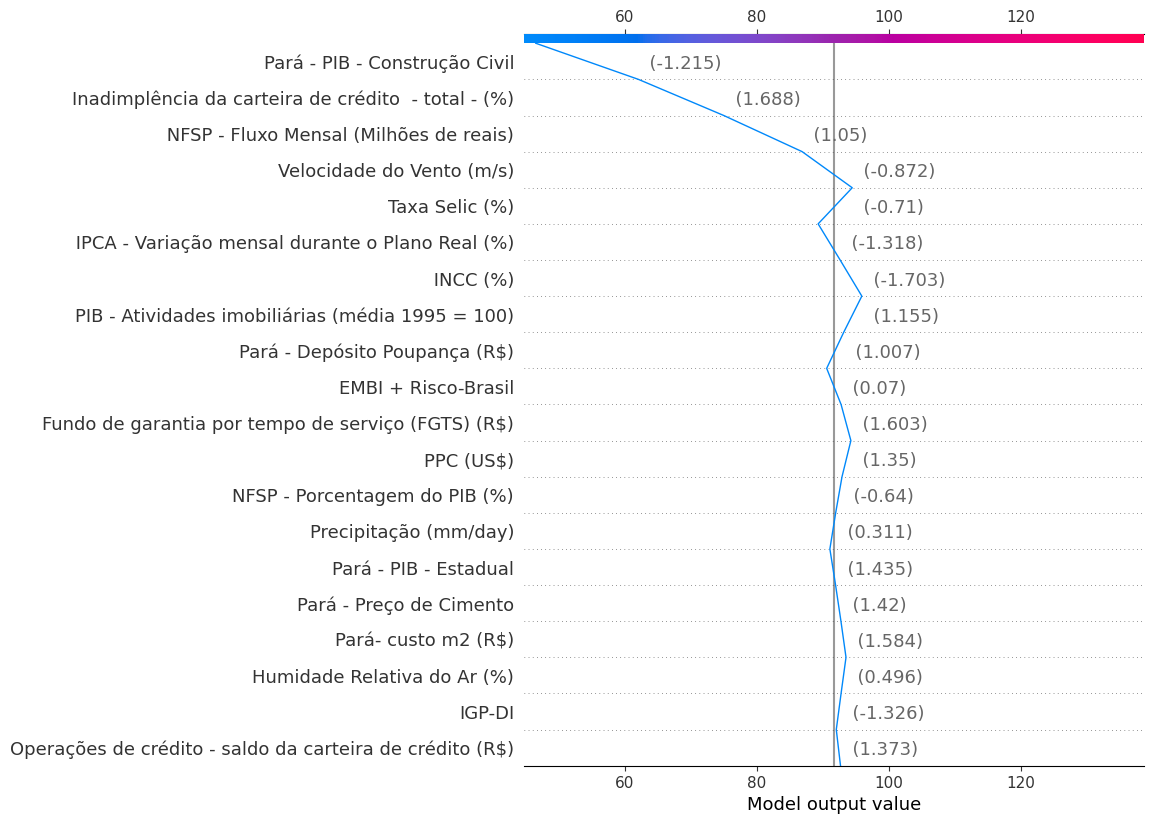

None

['Month-2', 114.885506, 91.638, 23.247505]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 551us/step


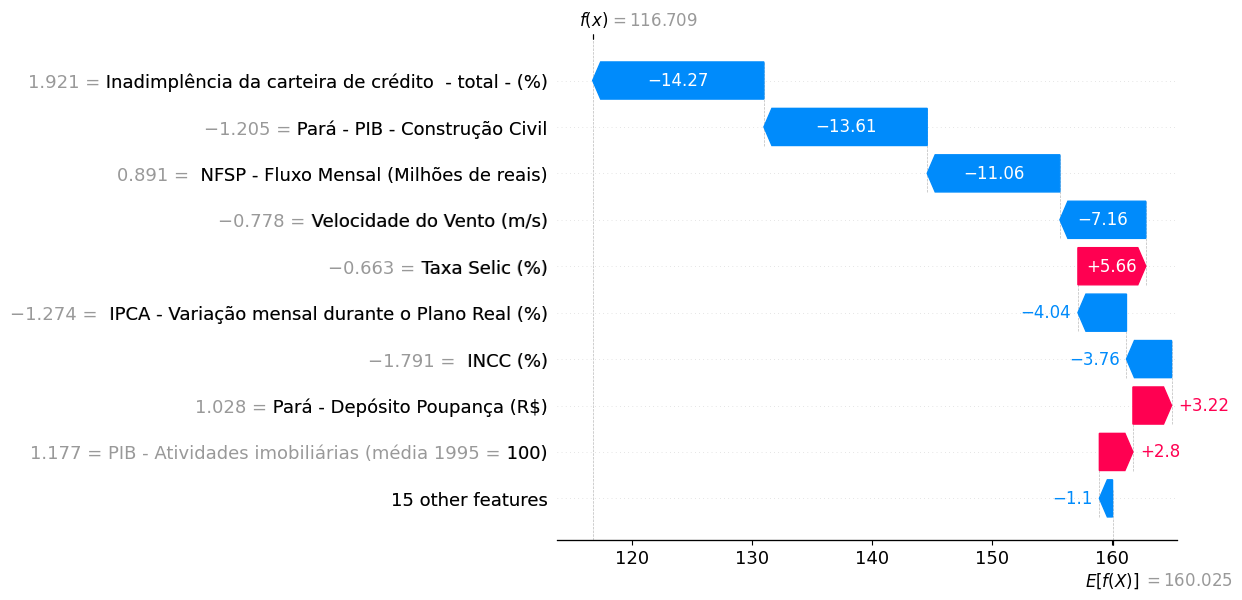

None

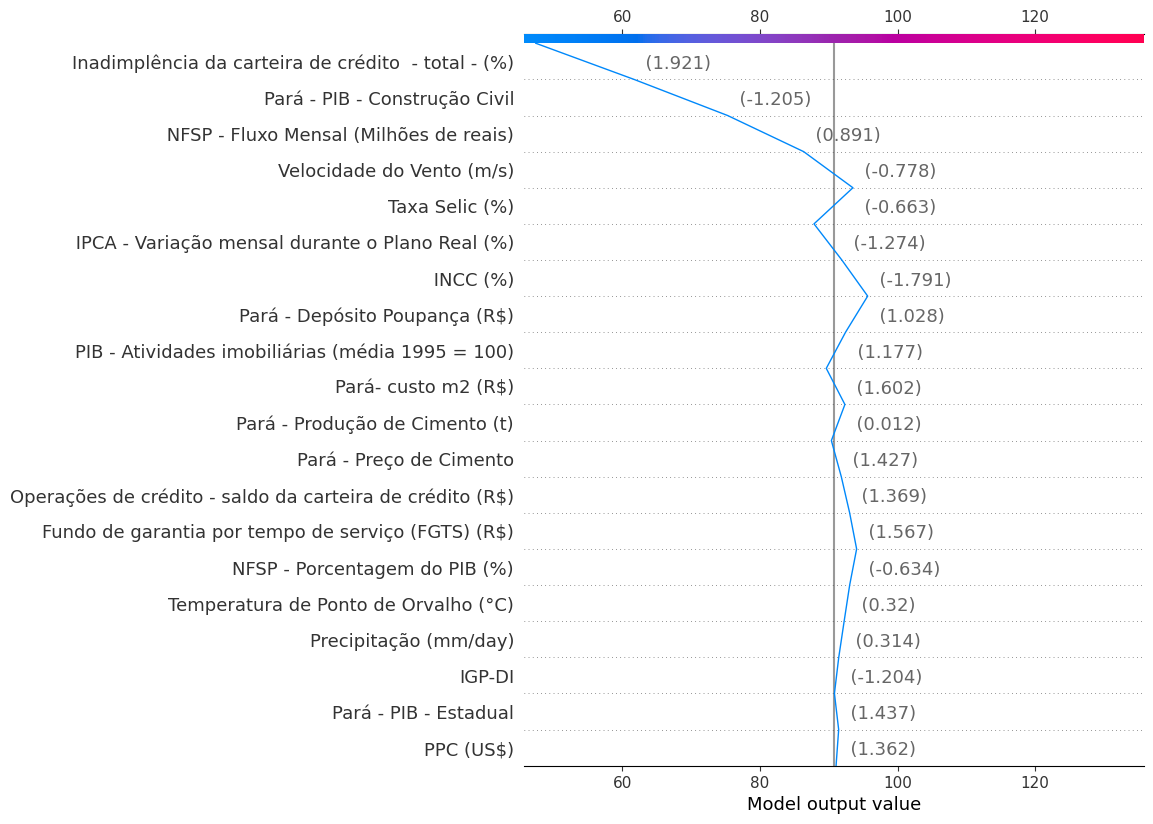

None

['Month-3', 116.70861, 90.744, 25.964607]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 549us/step


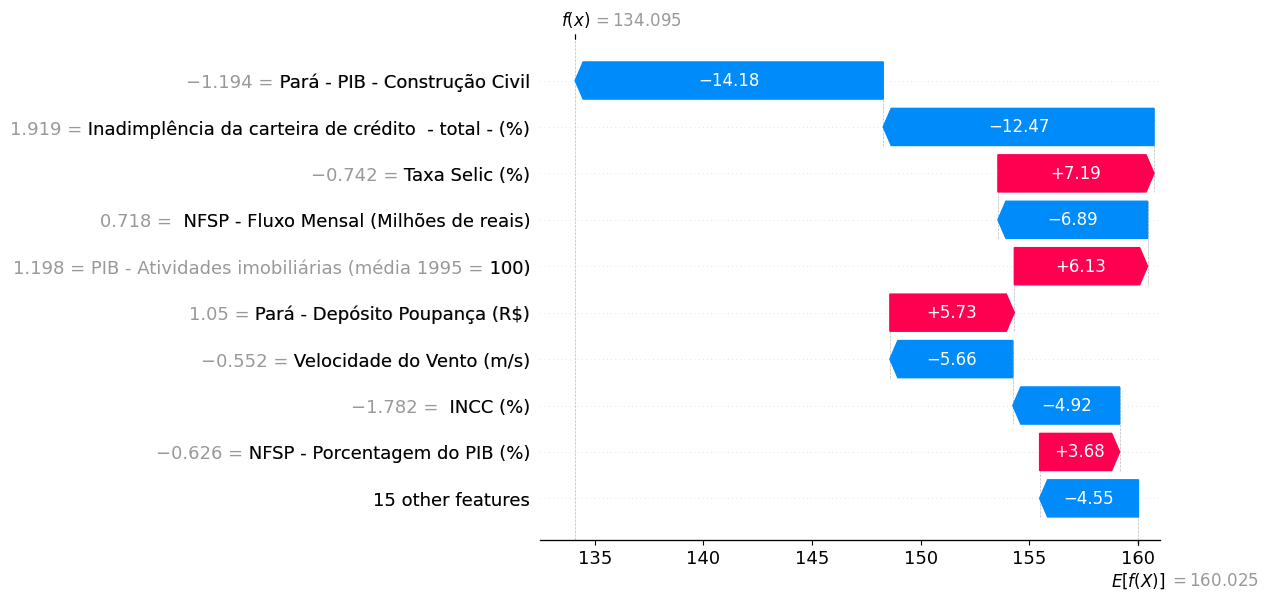

None

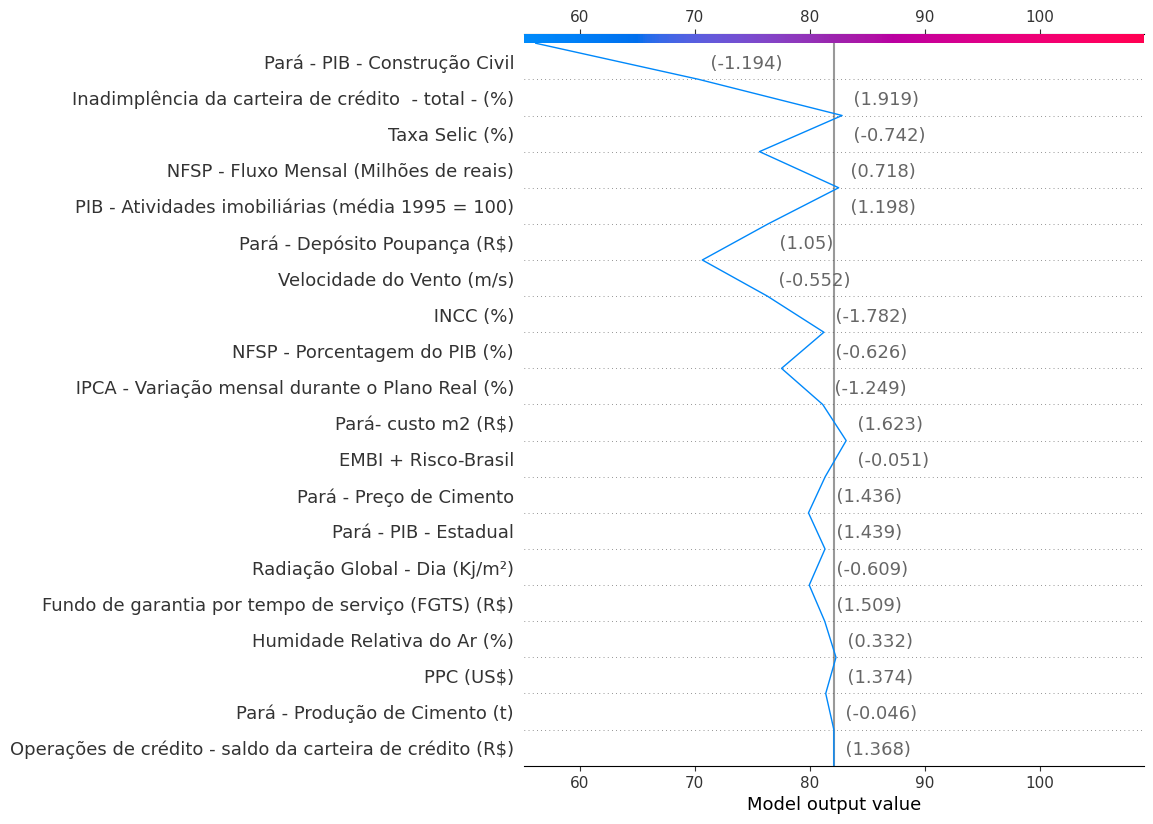

None

['Month-4', 134.0953, 82.108, 51.987305]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 547us/step


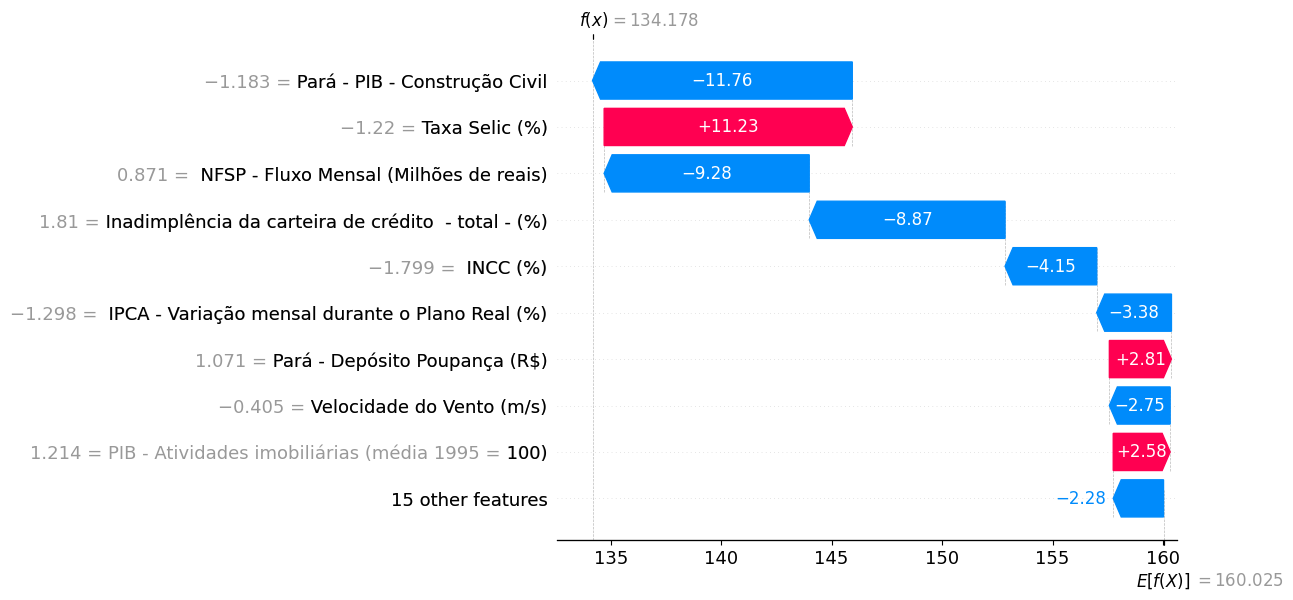

None

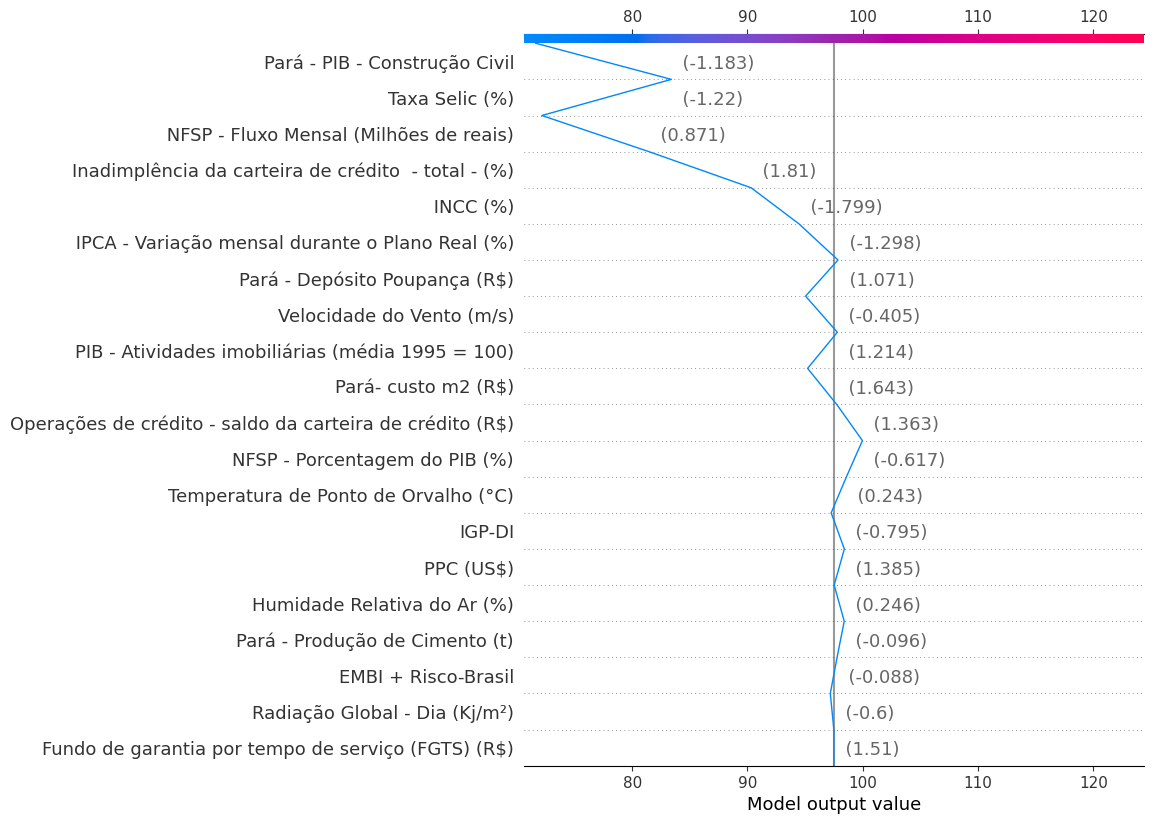

None

['Month-5', 134.17818, 97.49, 36.68818]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 540us/step


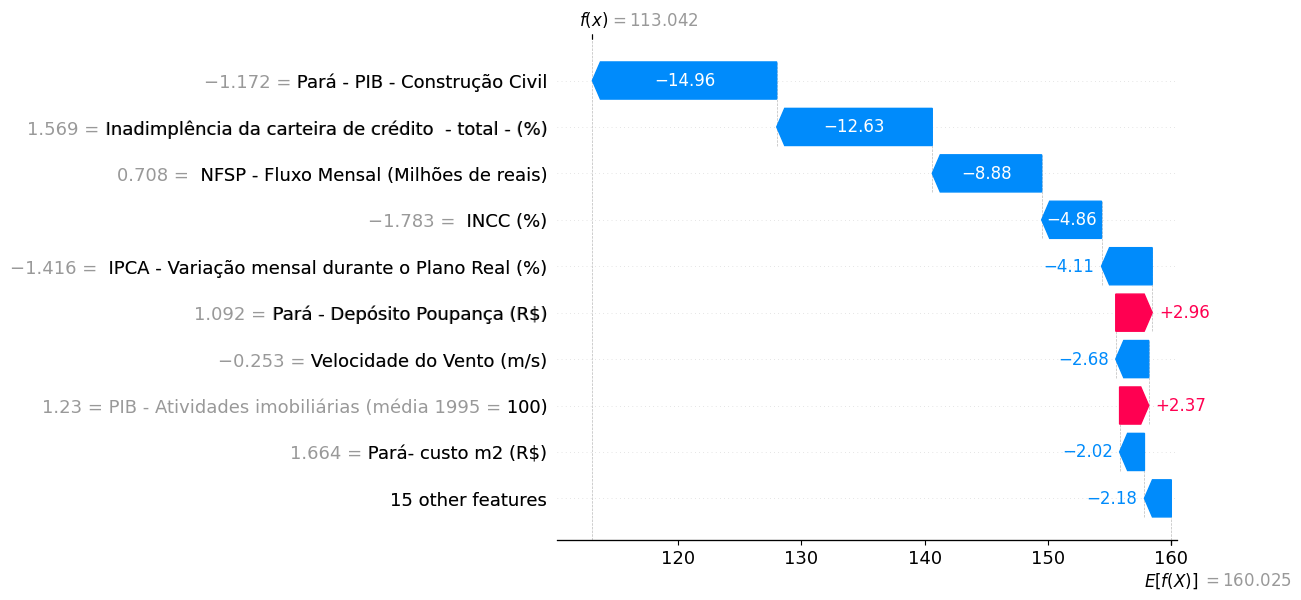

None

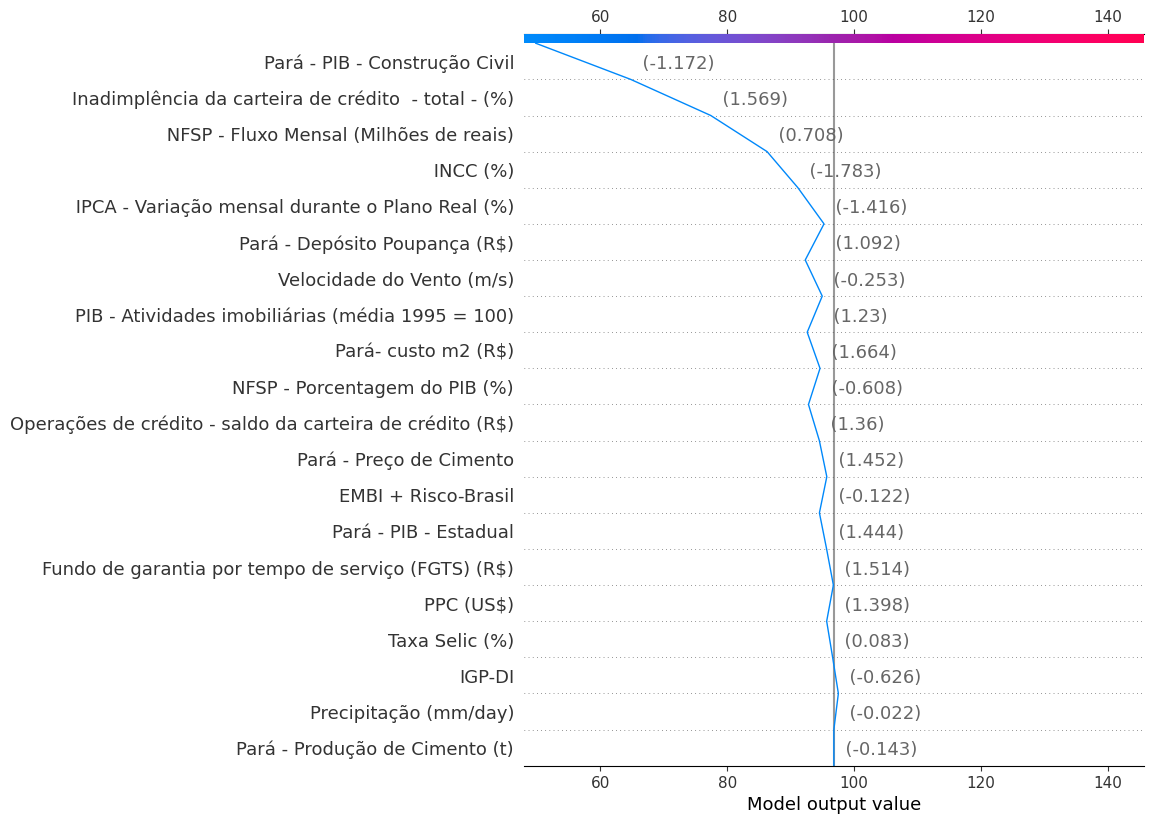

None

['Month-6', 113.04196, 96.803, 16.23896]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 544us/step


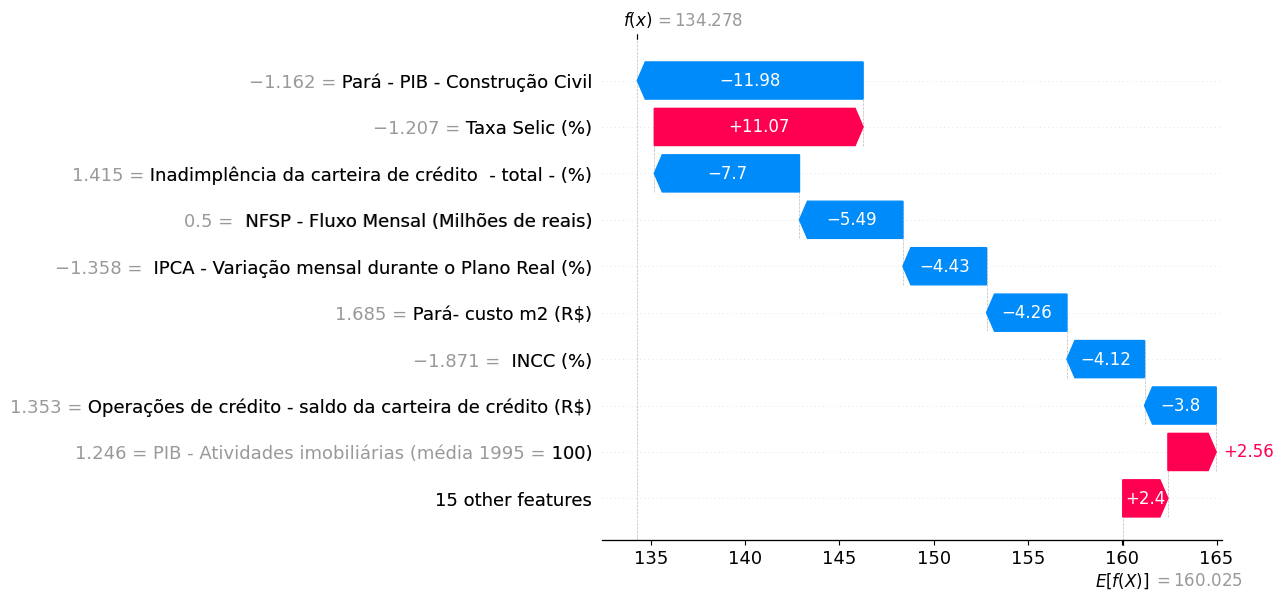

None

None

['Month-7', 134.27756, 118.687, 15.590561]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 661us/step


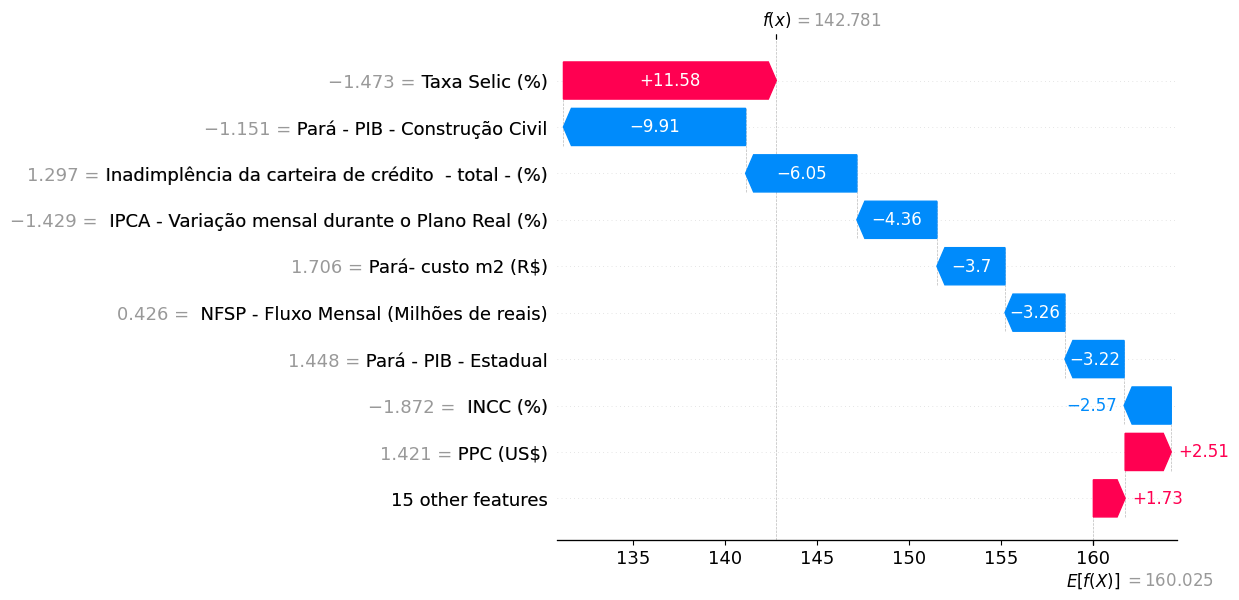

None

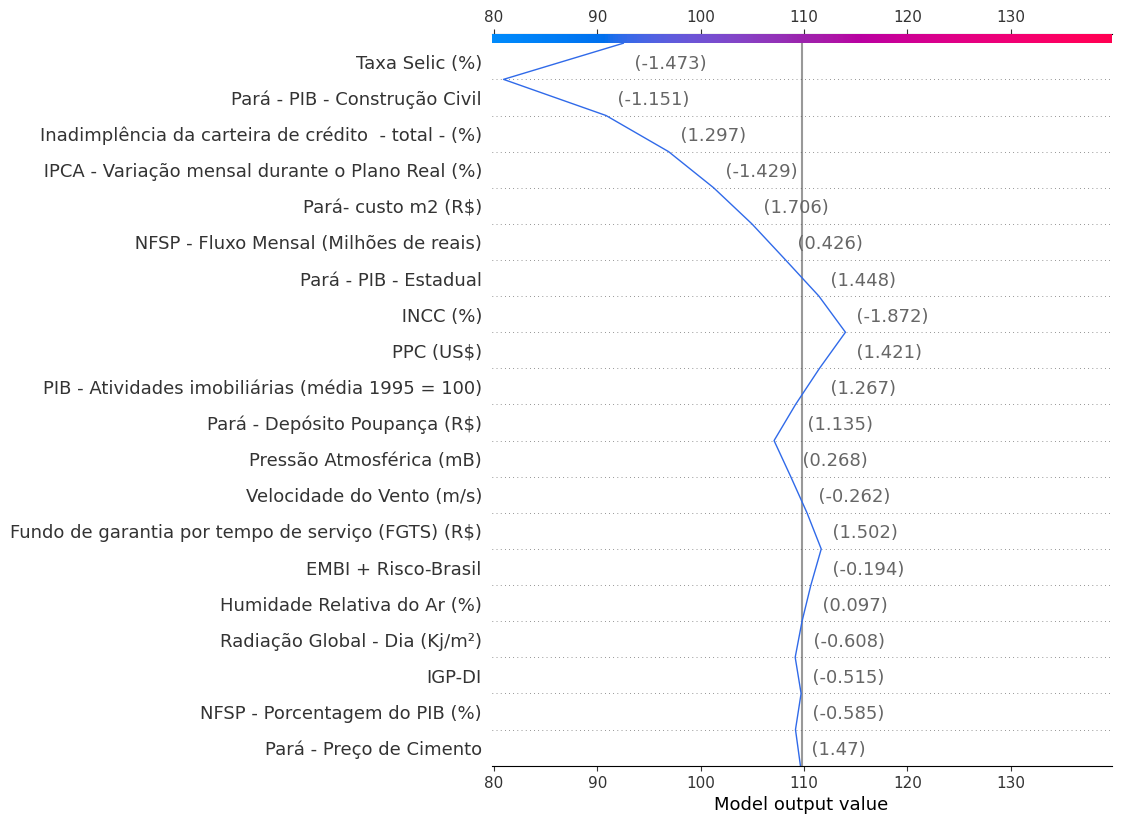

None

['Month-8', 142.7811, 109.761, 33.020096]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 569us/step


None

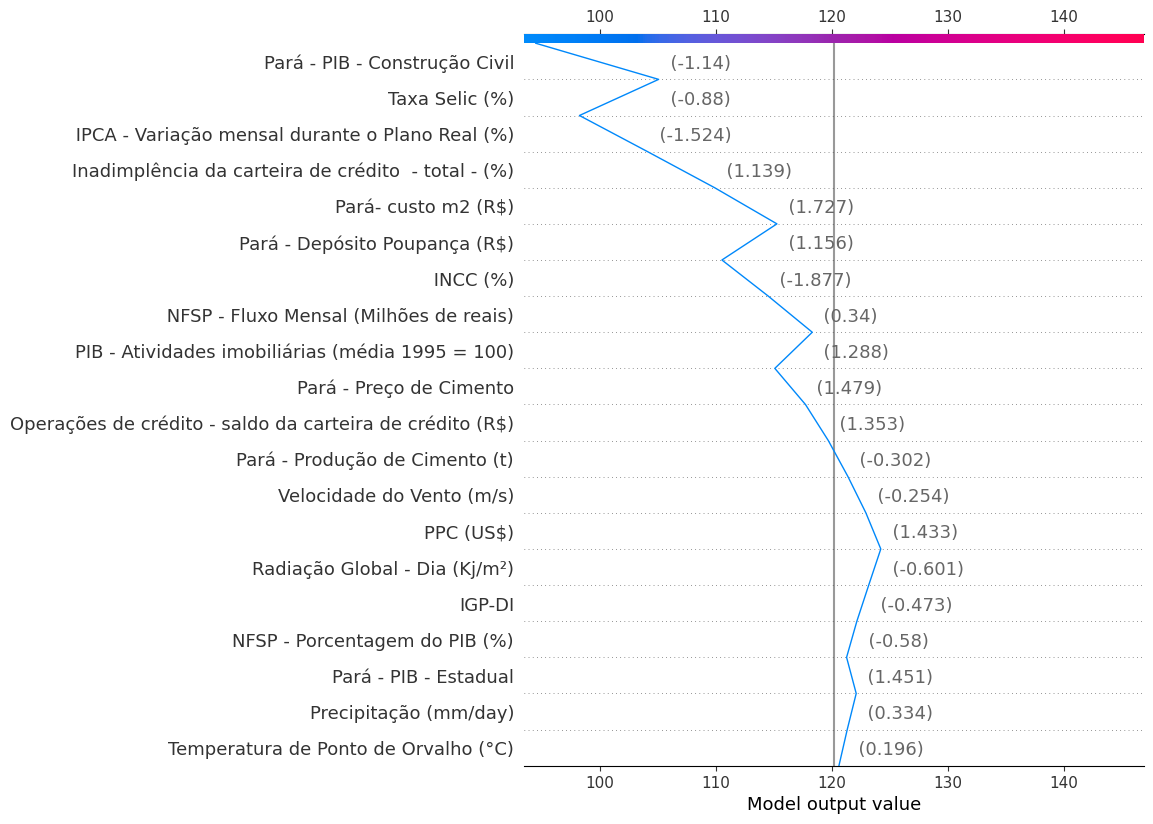

None

['Month-9', 134.33192, 120.188, 14.143921]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 600us/step


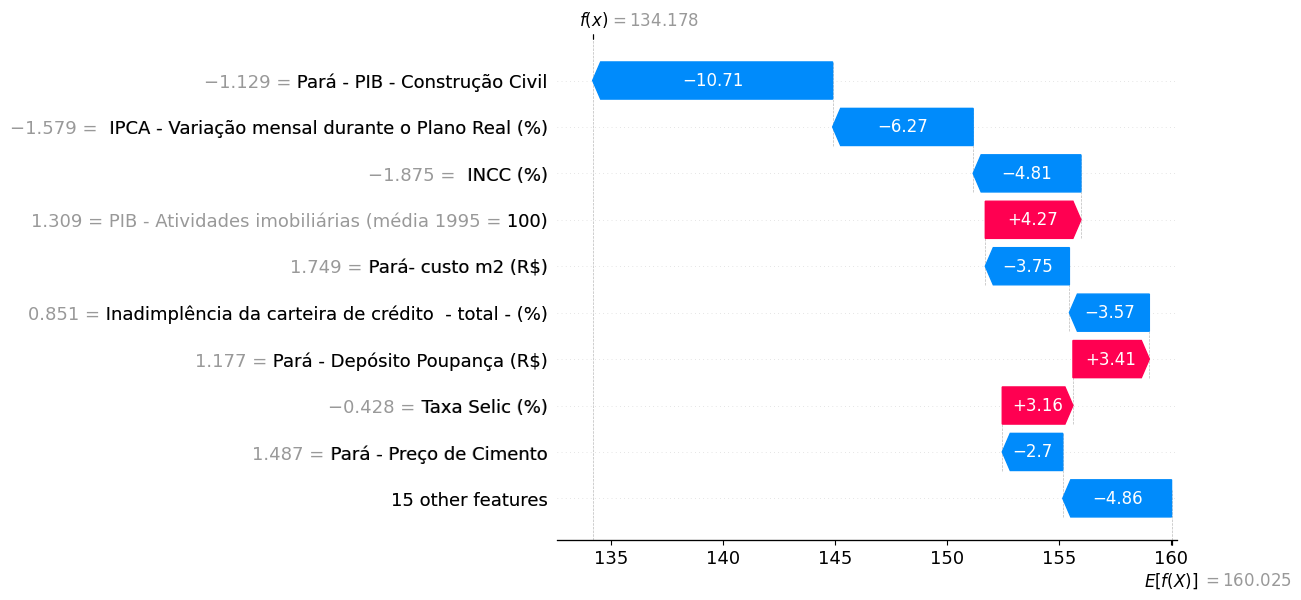

None

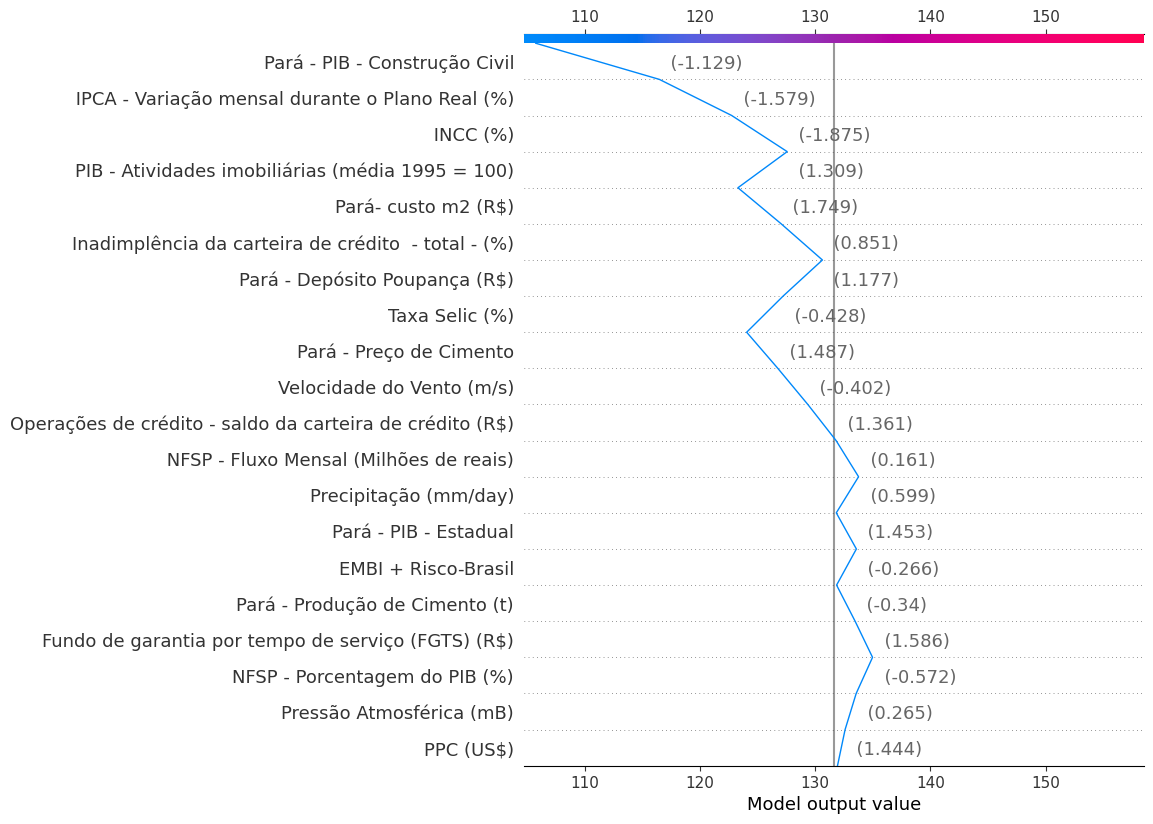

None

['Month-10', 134.17819, 131.62, 2.558197]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 548us/step


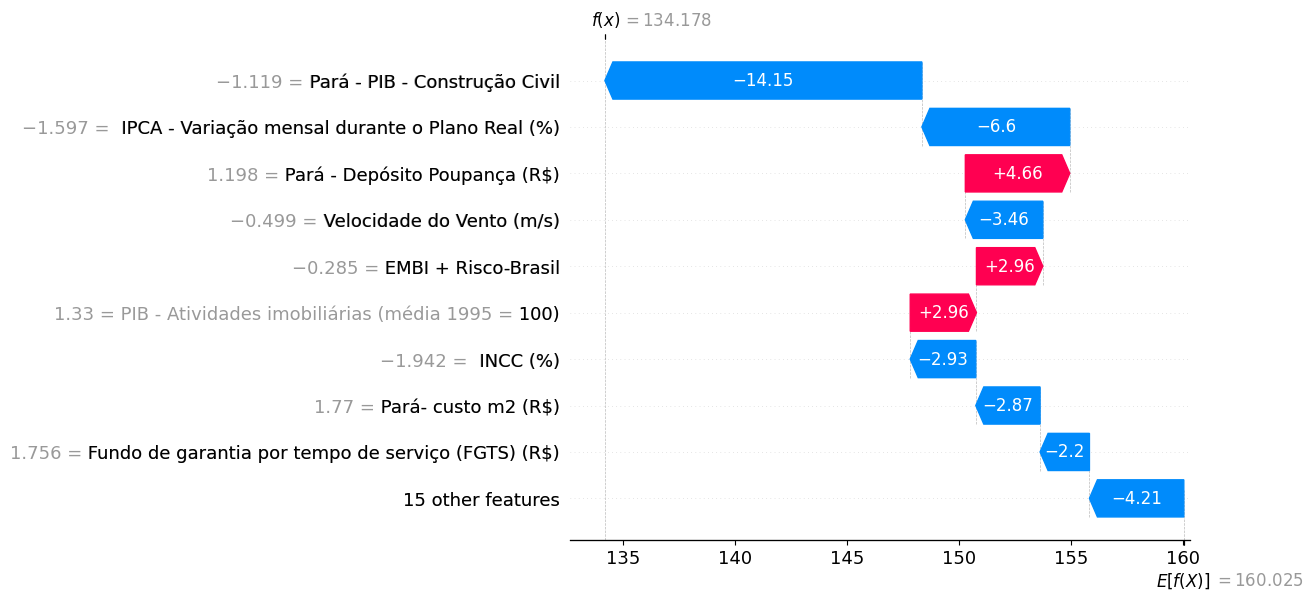

None

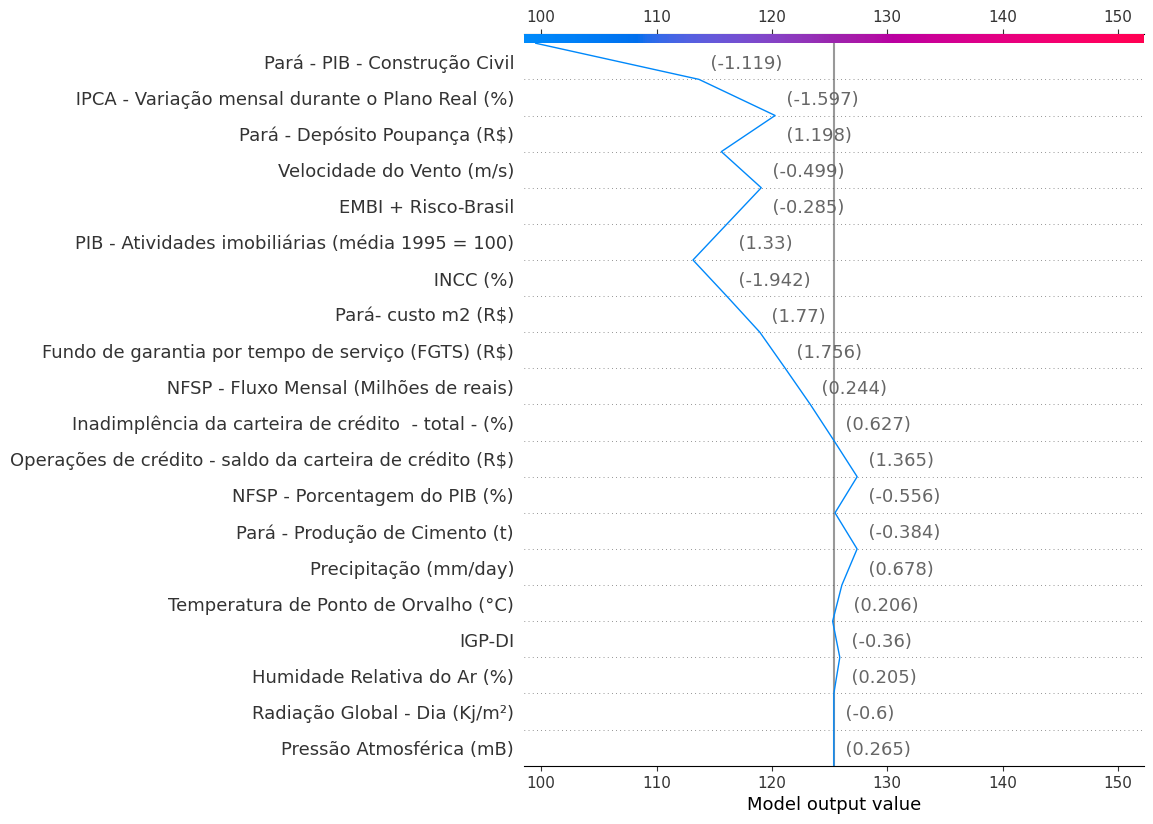

None

['Month-11', 134.17816, 125.374, 8.804161]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 584us/step


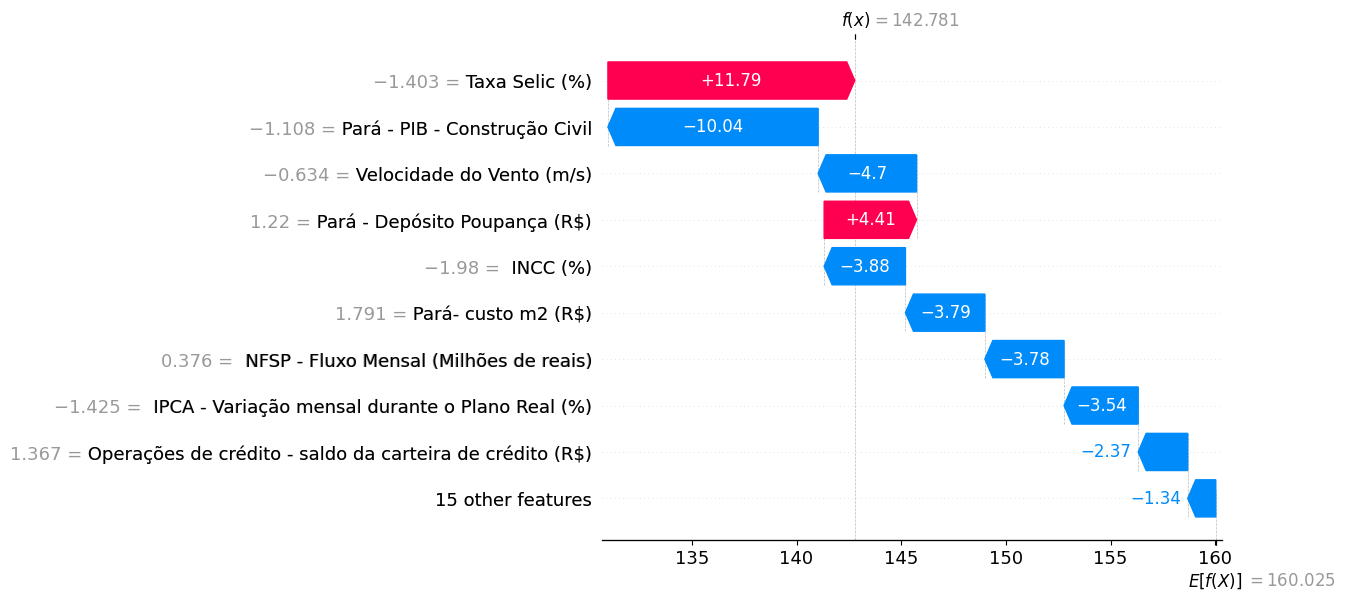

None

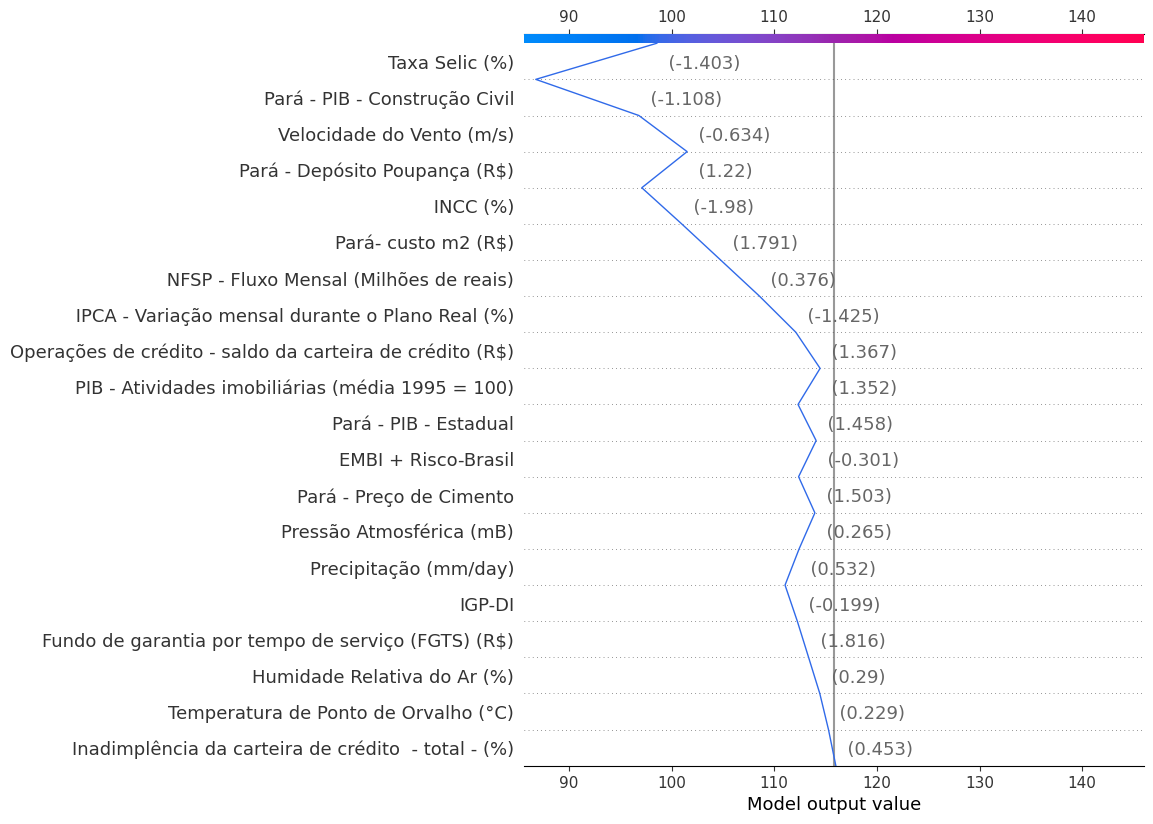

None

['Month-12', 142.7811, 115.811, 26.9701]

0           1           2           3           4   \
Month         Month-1     Month-2     Month-3     Month-4     Month-5   
Prediction  134.03688  114.885506  116.708611  134.095306  134.178177   
Target        110.704      91.638      90.744      82.108       97.49   
Error       23.332878   23.247505   25.964607   51.987305   36.688179   

                    5           6           7           8           9   \
Month          Month-6     Month-7     Month-8     Month-9    Month-10   
Prediction  113.041962  134.277557  142.781097  134.331924  134.178192   
Target          96.803     118.687     109.761     120.188      131.62   
Error         16.23896   15.590561   33.020096   14.143921    2.558197   

                    10          11  
Month         Month-11    Month-12  
Prediction  134.178162  142.781097  
Target         125.374     115.811  
Error         8.804161     26.9701

In [70]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            train_input,
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

In [71]:
display(mae)
display(mape)

23.212206

0.23335342